# DAT 402 Project 2

# Plant Disease Detection from Leaf Images

---

#### Team Members:
- Pete VanBenthuysen
- Emily Szolnoki
---

#### Project Goal:
The goal of this project is to predict whether a plant — specifically bell pepper, potato, or tomato — is healthy or afflicted by a specific disease based on an image of its leaf.
Rather than simply detecting the presence of disease, the model is designed to identify the exact type of illness, enabling farmers to make informed decisions about whether a plant is salvageable, treatable, or needs to be removed.

This project leverages deep learning to create a rapid, low-cost diagnostic tool for agriculture.
Early and accurate detection of plant diseases in these critical crops is essential for preventing crop loss, maintaining food supply chains, and promoting sustainable farming practices.

Traditional methods of diagnosing plant diseases can be slow, require expert knowledge, and are often inaccessible to farmers in rural or resource-limited settings.
By training a convolutional neural network (CNN) on a large dataset of real-world agricultural images, we aim to automate disease identification across a wide range of conditions with high accuracy.

This project demonstrates how machine learning can transform agriculture by making expert-level diagnostics accessible to everyone — helping farmers make faster, more informed decisions, reduce unnecessary pesticide use, improve crop yields, and enhance global food security.
It also opens pathways for building mobile applications or embedded systems that bring AI-powered diagnostics directly into the hands of agricultural workers worldwide.

---

#### Dataset:
We are using the "PlantVillage" dataset, sourced from Kaggle.  
The dataset contains over 20,000 labeled images of plant leaves, specifically focusing on three crops: bell peppers, potatoes, and tomatoes.
Each image is classified into one of 15 categories, representing either a specific disease or a healthy leaf.
The dataset is organized into folders based on the class label, with each folder containing images for a particular disease or healthy condition.
There are no missing values.
However, the distribution of images across classes is imbalanced, with certain diseases (such as Tomato Yellow Leaf Curl Virus) having significantly more samples than others (such as Potato healthy).

You can download the dataset [Here.](https://www.kaggle.com/datasets/emmarex/plantdisease)

After downloading, extract the contents into the `data/` folder of the project, preserving the folder structure.

In [1]:
# System and Path Management
import sys
from pathlib import Path
import os
# Add src/ to sys.path
src_path = Path(os.getcwd()).resolve().parent / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import shutil
import io
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
import collections

# Basic Libraries
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image
import cv2

# Data Preprocessing and Augmentation
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Machine Learning Models and Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# Deep Learning Libraries (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2

# Deep Learning Libraries (PyTorch)
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Model Persistence
import joblib

# Project-Specific Modules
import config
print(f"Using config from: {config.__file__}")
print(f"DATA_DIR path: {config.DATA_DIR}")

from functions import (
    count_images_per_class,
    plot_rf_class_distribution,
    plot_cnn_class_distribution,
    is_valid_file,
    print_class_distribution_with_names,
    plot_class_distribution,
    load_images_and_labels,
    group_and_report_crop_distribution,
    is_folder_complete,
    apply_transformations_and_save,
    extract_and_pivot_gridsearch_train,
    plot_rf_confusion_matrix_train,
    plot_rf_heatmap_train,
    save_rf_gridsearch_metadata_train,
    evaluate_and_visualize_model,
    build_improved_cnn_model,
    tta_predict,
    save_cnn_metrics_to_json,
    save_model_summary_arch_weights,
    plot_rf_confusion_matrix_test,
    plot_rf_probabilities_heatmap_test,
    plot_rf_feature_importance_test,
    plot_confusion_matrix_cnn_test,
    plot_prediction_explanation_grid,
    plot_cnn_probabilities_heatmap_test,
    plot_crop_distribution,
    apply_leaf_mask,
    mask_and_save_all_images,
    is_split_complete,
    save_cnn_split,
    show_random_images,
    plot_compressed_scatter,
    plot_cluster_scatter,
    plot_autoencoder_loss_curve,
    plot_bottleneck_vs_loss,
    plot_final_autoencoder_loss,
    build_autoencoder,
    plot_top20_gridsearch_models
)

[CONFIG] DATA_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\data
[CONFIG] MASKED_DATA_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\masked_data
[CONFIG] OUTPUTS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs
[CONFIG] RF_SPLITS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_rf
[CONFIG] CNN_SPLITS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn_transformed
[CONFIG] CNN_VAL_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\val
[CONFIG] CNN_TEST_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\test
[CONFIG] RF_TEST_RESULTS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf
Using config from: C:\Users\petev\OneDrive\Desktop\LeafLens\src\config.py
DATA_DIR path: C:\Users\petev\OneDrive\Desktop\LeafLens\data


We begin by importing all essential libraries for data handling, visualization, machine learning, and deep learning. This also includes custom utility functions from `functions.py` and predefined directory paths from `config.py`. This modular structure promotes maintainability, consistency, and reliable access to shared components across the entire project pipeline.

In [2]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cpu


Next, we check for GPU availability to accelerate model training. To ensure reproducibility across multiple runs, we also set random seeds for `torch`, `numpy`, and Python's `random` module early in the workflow. This controls stochastic processes such as data splitting, model initialization, and sampling, enabling consistent and comparable results across experiments [1].

###### [1] [PyTorch Reproducibility Guide](https://pytorch.org/docs/stable/notes/randomness.html)

No duplicate folder found at: c:\Users\petev\OneDrive\Desktop\LeafLens\data\PlantVillage\PlantVillage
Number of categories (classes): 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Saved class names to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\class_names.json
Skipped invalid image C:\Users\petev\OneDrive\Desktop\LeafLens\data\PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c under category 'Tomato__Tomato_YellowLeaf__Curl_Virus': cannot identify image file 'C:\\Users\\petev\\OneDrive\\Desktop\\LeafLens\\data\\PlantVillage\\Tomato__Tomato_YellowLeaf__Curl_Virus\\svn-r6Yb5c'

Total images loaded: 20638

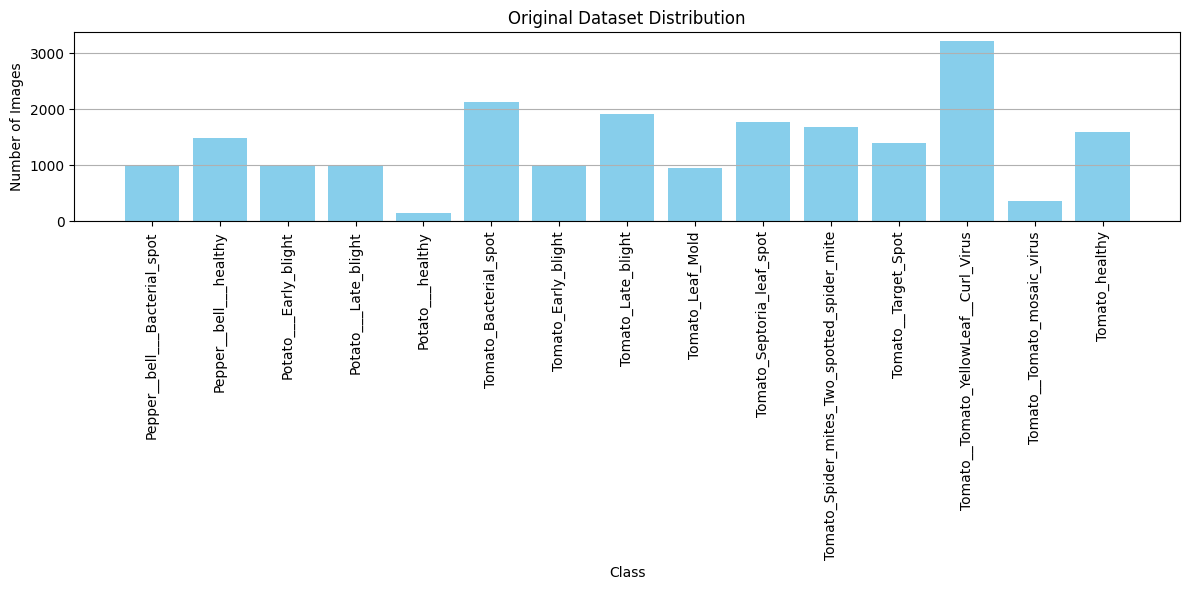


--- Observations ---
The dataset covers 15 different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.
Images are consistently resized to 128x128 pixels with 3 color channels (RGB).

--- Grouped Class Distribution ---

--- Potato Dataset ---
Healthy: 152 images
Infected (Potato___Early_blight): 1000 images
Infected (Potato___Late_blight): 1000 images


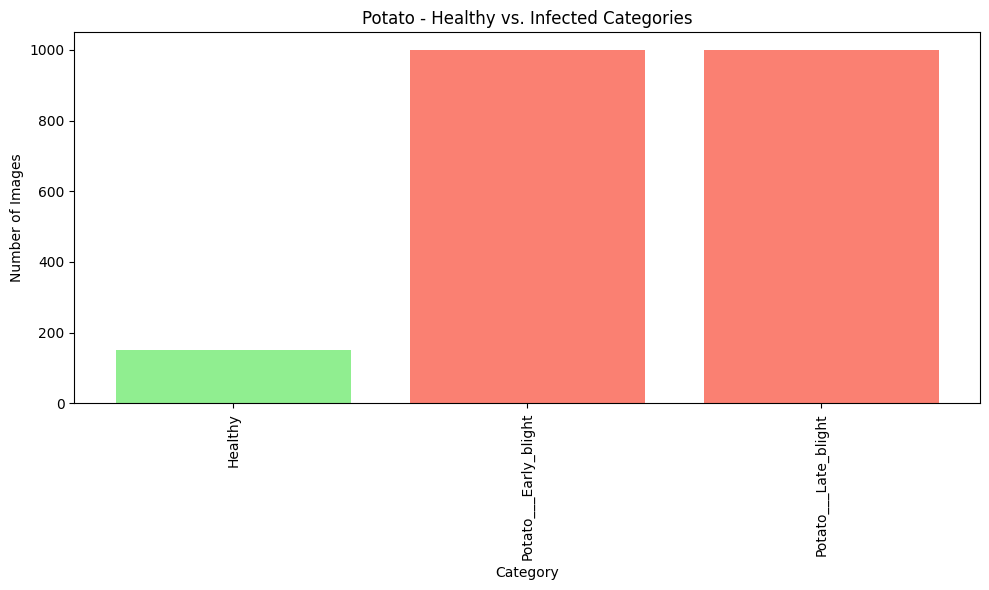


--- Pepper Dataset ---
Healthy: 1478 images
Infected (Pepper__bell___Bacterial_spot): 997 images


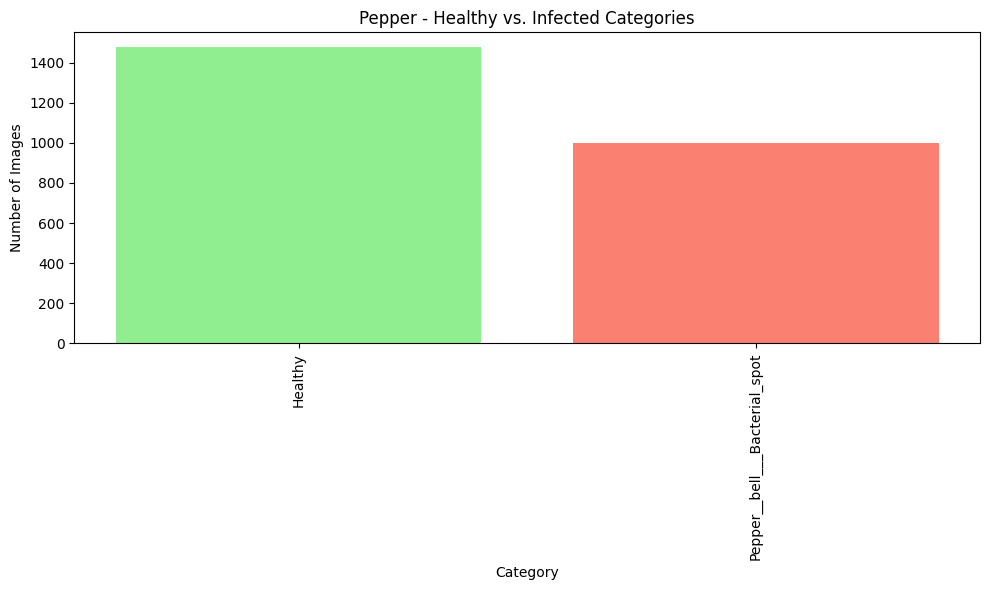


--- Tomato Dataset ---
Healthy: 1591 images
Infected (Tomato_Bacterial_spot): 2127 images
Infected (Tomato_Early_blight): 1000 images
Infected (Tomato_Late_blight): 1909 images
Infected (Tomato_Leaf_Mold): 952 images
Infected (Tomato_Septoria_leaf_spot): 1771 images
Infected (Tomato_Spider_mites_Two_spotted_spider_mite): 1676 images
Infected (Tomato__Target_Spot): 1404 images
Infected (Tomato__Tomato_YellowLeaf__Curl_Virus): 3208 images
Infected (Tomato__Tomato_mosaic_virus): 373 images


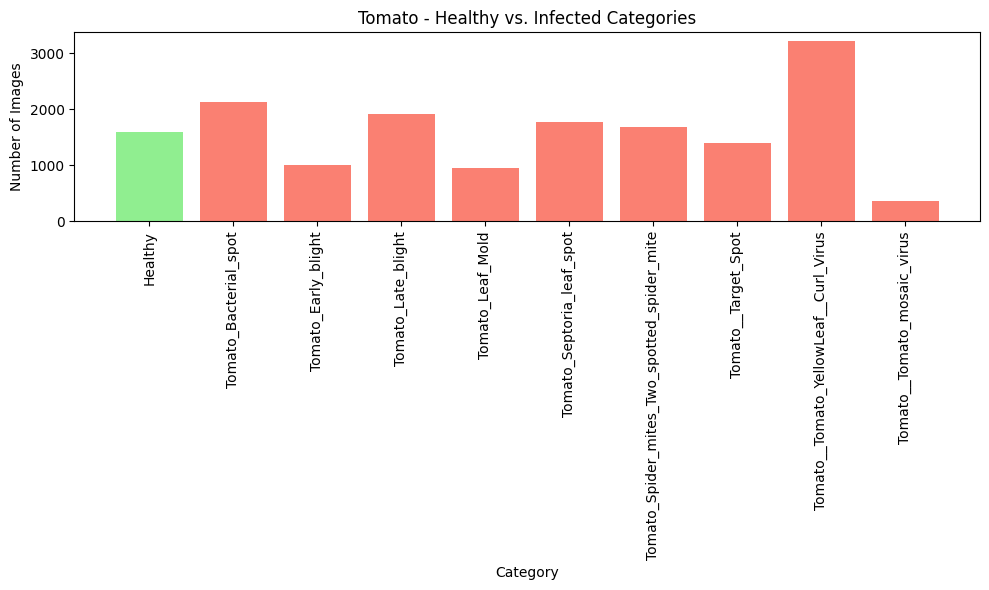

Saved plot to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\potato_distribution.png


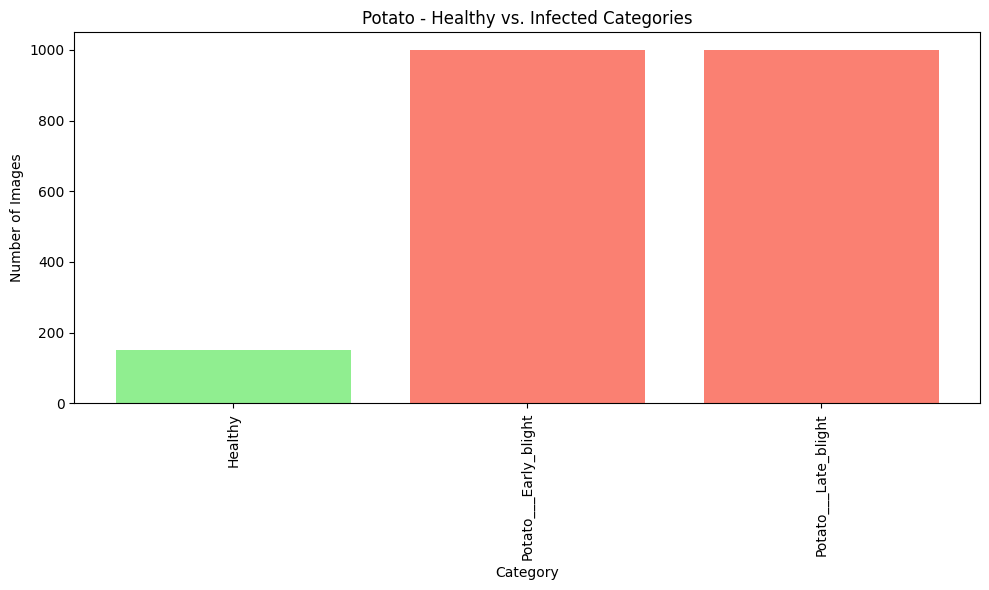

Saved plot to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\pepper_distribution.png


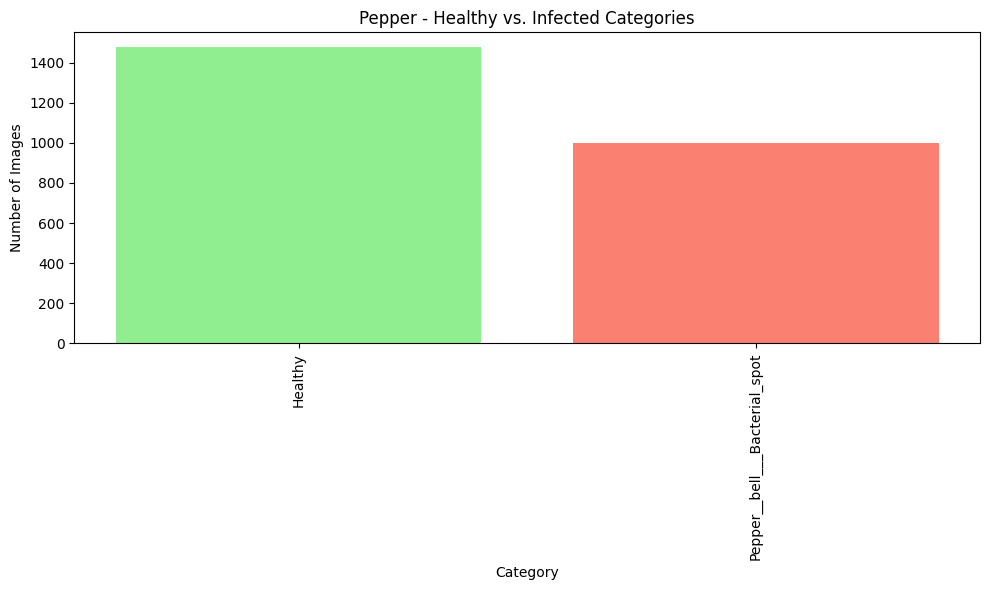

Saved plot to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\tomato_distribution.png


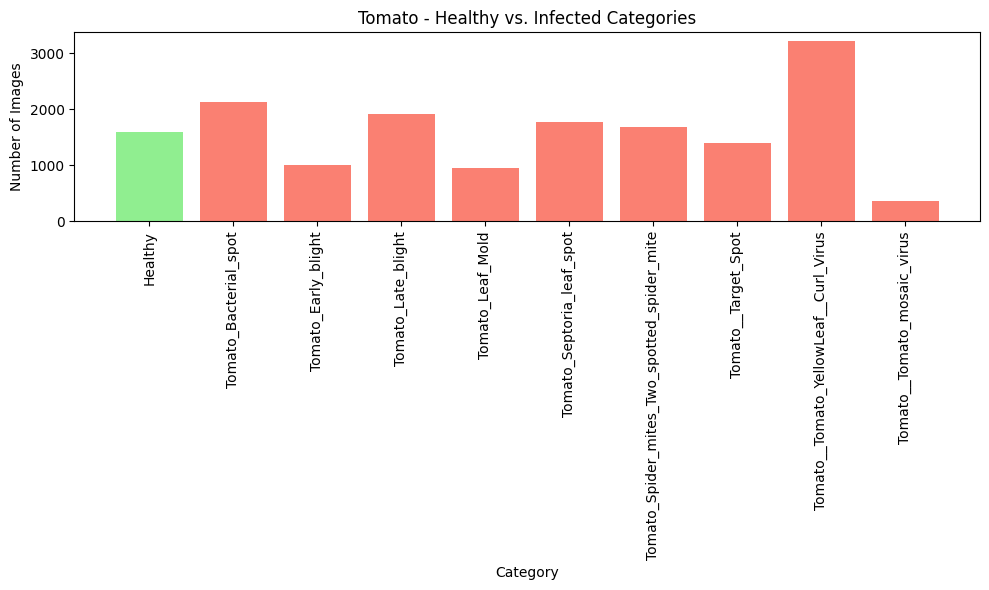

In [3]:
# Define the path to the main PlantVillage folder
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "PlantVillage"))

# Define the path to the duplicate PlantVillage folder
duplicate_path = os.path.join(base_path, "PlantVillage")

# Check if the duplicate folder exists
if os.path.exists(duplicate_path):
    print(f"Duplicate folder found at: {duplicate_path}")
    # Remove the duplicate folder and its contents
    shutil.rmtree(duplicate_path)
    print(f"Duplicate folder removed: {duplicate_path}")
else:
    print(f"No duplicate folder found at: {duplicate_path}")

# List categories (subfolders inside PlantVillage)
categories = sorted([folder.name for folder in config.PLANT_VILLAGE_PATH.iterdir() if folder.is_dir()])
print(f"Number of categories (classes): {len(categories)}")
print("Classes:", categories)

# Save class names to a JSON file
with open(config.OUTPUTS_DIR / "class_names.json", "w") as f:
    json.dump(categories, f)
print(f"Saved class names to {config.OUTPUTS_DIR / 'class_names.json'}")

# Load images and labels
images, labels, skipped_images = load_images_and_labels(config.PLANT_VILLAGE_PATH, categories)

# Print basic dataset characteristics
print(f"\nTotal images loaded: {images.shape[0]}")
print(f"Each image shape: {images.shape[1:]} (Height x Width x Channels)")
print(f"Labels shape: {labels.shape}")

# Print skipped images summary
print("\n--- Skipped Images Summary ---")
for category, count in skipped_images.items():
    print(f"Category '{category}': {count} images skipped")

# Plot a bar chart of class distribution
plot_class_distribution(
    labels,
    categories,
    title="Original Dataset Distribution",
    save_path=config.EDA_DIR / "original_dataset_distribution.png"
)

# Print observations
print("\n--- Observations ---")
print(f"The dataset covers {len(categories)} different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.")
print("Images are consistently resized to 128x128 pixels with 3 color channels (RGB).")

# Print grouped class distribution
print("\n--- Grouped Class Distribution ---")
labels_df = pd.DataFrame({'label': labels})
class_counts = labels_df['label'].value_counts().sort_index()

# Count healthy and infected images for each crop
crops = group_and_report_crop_distribution(class_counts, categories, plot_func=plot_crop_distribution)

# Save each crop's distribution plot to outputs/EDA
eda_dir = config.EDA_DIR 
eda_dir.mkdir(parents=True, exist_ok=True)

for crop_name, crop_data in crops.items():
    save_path = eda_dir / f"{crop_name.lower().replace(' ', '_')}_distribution.png"
    plot_crop_distribution(crop_name, crop_data, save_path=save_path)

#### Quality Checks

First, we check to make sure no duplicate folders exist. If they do and their contents are the same, it is deleted.

#### Dataset Description

The PlantVillage dataset is organized into 15 distinct classes, with each class represented as a subfolder under the `PlantVillage` directory.  
Each subfolder corresponds to a specific plant disease or a healthy plant condition across bell peppers, potatoes, and tomatoes.

#### Data Loading and Cleaning Steps

- For each class, all files within its subfolder were iterated.
- Only valid image files (non-directories) were processed.
- Images were opened with the Pillow (PIL) library, converted to RGB, and resized to 128×128 pixels [2].
- Invalid or unreadable files (e.g., corrupted or non-image files) were safely skipped without interrupting the loading process.
- Skipped images were tracked per category for auditing purposes.
- Saved class_names as a json file for future reference [3].

#### Dataset Characteristics

- Total of 20,638 valid images successfully loaded.
- Each image is a NumPy array of shape (128, 128, 3).
- Labels were assigned as integer IDs (0–14) based on the alphabetical order of class names.

#### Observations

- The dataset exhibits a class imbalance, with diseases like *Tomato Yellow Leaf Curl Virus* overrepresented compared to others like *Potato Healthy*. 
- Addressing class imbalance during model training (e.g., through data augmentation or class-weighted loss) is important to prevent bias.
- The dataset is rich, diverse, and well-structured, providing a strong foundation for developing machine learning models, particularly Convolutional Neural Networks (CNNs) for image classification tasks.

- Across the datasets, a notable class imbalance between healthy and infected samples exists.
- Potato shows a severe shortage of healthy samples (152 vs 2000 infected), while Pepper is more balanced.
- Tomato is strongly dominated by infected samples, with several disease classes individually surpassing the number of healthy images.
- Such imbalances must be considered carefully during model development to avoid biased learning outcomes.

###### [2] [Pillow Documentation](https://realpython.com/image-processing-with-the-python-pillow-library/) 
###### [3] [JSON syntax](https://docs.python.org/3/library/json.html)

In [4]:
"""
# Mask all images
mask_and_save_all_images()

# List categories for masked data
categories = sorted([folder.name for folder in (config.MASKED_DATA_DIR / "PlantVillage").iterdir() if folder.is_dir()])

# Load masked images and labels (already returns np.array)
images, labels = load_images_and_labels_from_path(config.MASKED_DATA_DIR / "PlantVillage", categories)

print(f"Loaded {len(images)} masked images.")
print(f"Unique classes found: {len(np.unique(labels))}")

config.MASKED_ARRAYS_DIR.mkdir(parents=True, exist_ok=True)
np.save(config.MASKED_ARRAYS_DIR / 'images.npy', images)
np.save(config.MASKED_ARRAYS_DIR / 'labels.npy', labels)
"""

'\n# Mask all images\nmask_and_save_all_images()\n\n# List categories for masked data\ncategories = sorted([folder.name for folder in (config.MASKED_DATA_DIR / "PlantVillage").iterdir() if folder.is_dir()])\n\n# Load masked images and labels (already returns np.array)\nimages, labels = load_images_and_labels_from_path(config.MASKED_DATA_DIR / "PlantVillage", categories)\n\nprint(f"Loaded {len(images)} masked images.")\nprint(f"Unique classes found: {len(np.unique(labels))}")\n\nconfig.MASKED_ARRAYS_DIR.mkdir(parents=True, exist_ok=True)\nnp.save(config.MASKED_ARRAYS_DIR / \'images.npy\', images)\nnp.save(config.MASKED_ARRAYS_DIR / \'labels.npy\', labels)\n'

#### Masking Data

The purpose of masking is to reduce background noise and emphasize the most relevant features within an image — typically the object of interest, such as a leaf. For convolutional neural networks (CNNs), which learn spatial hierarchies of patterns, unmasked backgrounds can introduce misleading textures or shapes that detract from accurate feature learning. For random forest (RF) models, which rely on engineered features from pixel intensities or compressed representations, background noise can dilute the signal by adding irrelevant variance.

In our case, the dataset consisted of images with clean, uniform backgrounds, so explicit masking was not necessary during initial training. However, the project pipeline is designed to support masked inputs. If future datasets contain more complex or noisy backgrounds, the model can be retrained with masked data to enhance robustness and generalization to new environments [4].

###### [4] [Image Masking in Deep Learning](https://retouchinglabs.com/what-is-the-purpose-of-image-masking-in-deep-learning/)

Number of images: 20638
Number of labels: 20638
Shape after flattening: (20638, 49152)
Training Autoencoder with bottleneck_dim = 100
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 437ms/step - loss: 0.0296 - val_loss: 0.0251
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - loss: 0.0232 - val_loss: 0.0193
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - loss: 0.0197 - val_loss: 0.0192
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step - loss: 0.0187 - val_loss: 0.0178
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 419ms/step - loss: 0.0177 - val_loss: 0.0170
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - loss: 0.0163 - val_loss: 0.0161
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - loss: 0.0163 - val_loss: 0.0152
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - loss: 0.0155 - val_loss: 0.

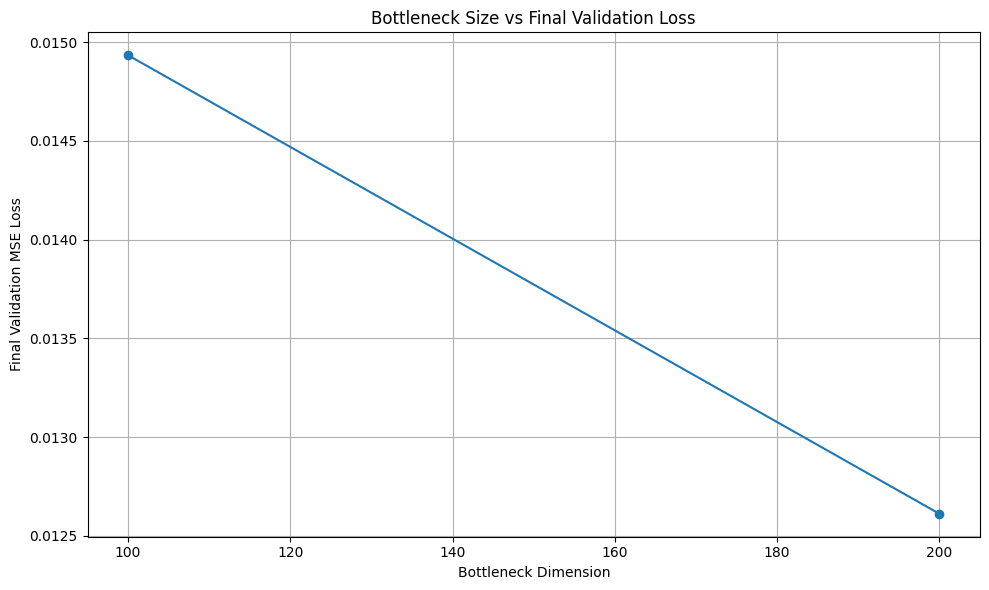

Saved bottleneck vs loss graph to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\bottleneck_vs_loss.png
Best bottleneck dimension selected: 200
Saved optimization results JSON to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\bottleneck_optimization_results.json
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 410ms/step - loss: 0.0290 - val_loss: 0.0238
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - loss: 0.0223 - val_loss: 0.0203
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - loss: 0.0192 - val_loss: 0.0183
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - loss: 0.0186 - val_loss: 0.0173
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - loss: 0.0173 - val_loss: 0.0168
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 388ms/step - loss: 0.0168 - val_loss: 0.0156
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 9/50
65/65 ━━━━━━━━━━━━

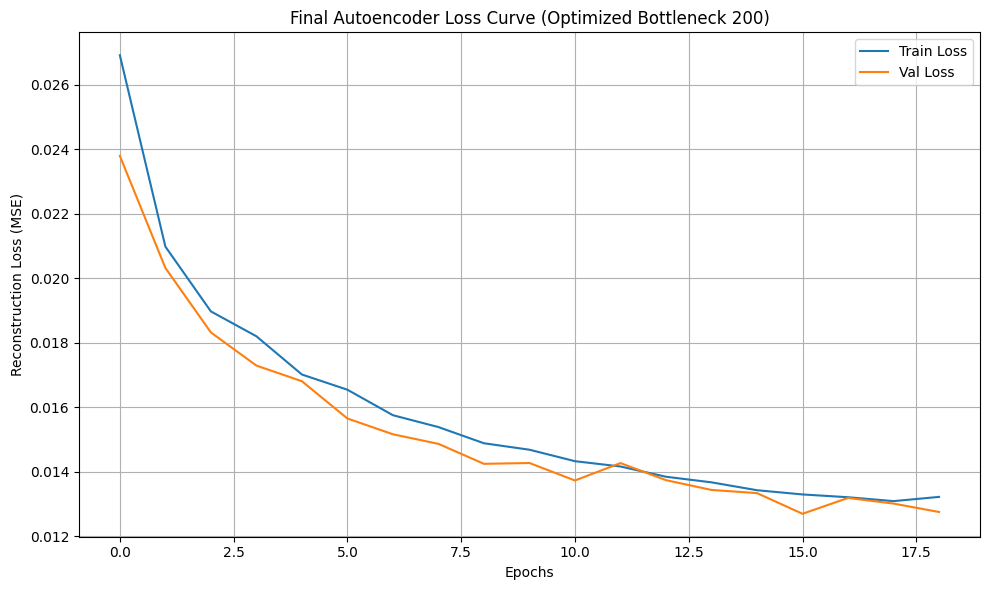

Saved final optimized loss curve to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\optimized_autoencoder_loss_curve.png
Saved final optimized loss curve to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\EDA\optimized_autoencoder_loss_curve.png
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Compressed features shape: (20638, 200)
Saved bottleneck feature names to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\feature_names.json
Shape after t-SNE reduction: (20638, 2)


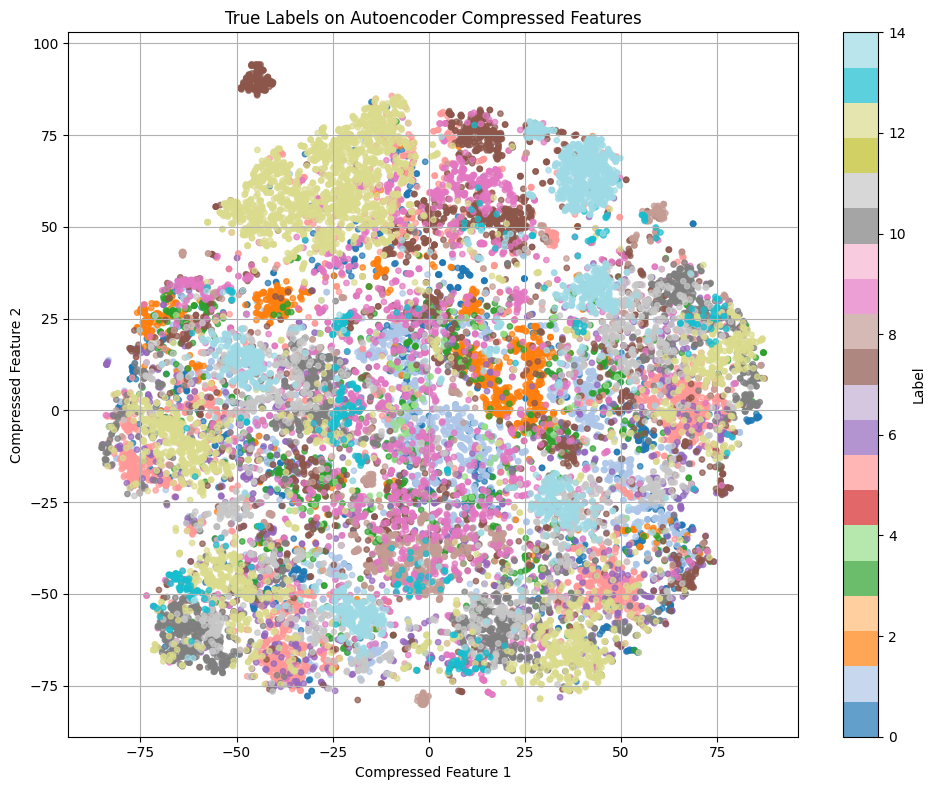

Cluster assignments shape: (20638,)


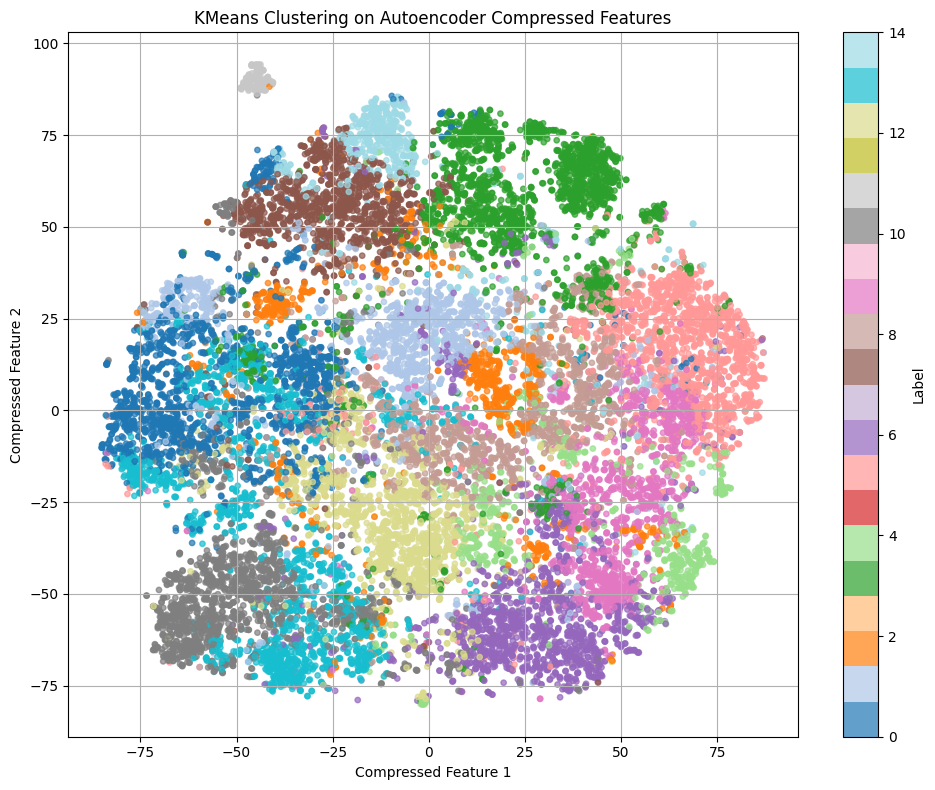

In [5]:
# Check the number of images and labels
print(f"Number of images: {images.shape[0]}")
print(f"Number of labels: {len(labels)}")

# Ensure the number of labels matches the number of images
assert len(labels) == images.shape[0], "Mismatch between the number of images and labels"

# Flatten and normalize pixel values
X_flat = images.reshape(images.shape[0], -1) / 255.0
print(f"Shape after flattening: {X_flat.shape}")

# Split for training the Autoencoder
train_images, val_images = train_test_split(X_flat, test_size=0.2, random_state=42)

input_dim = train_images.shape[1]

# List of bottleneck sizes to test
bottleneck_candidates = [100, 200,] #Training on CPU takes too long for larger sizes
bottleneck_results = {}

# Train Autoencoders with different bottlenecks
for bottleneck_dim in bottleneck_candidates:
    print(f"Training Autoencoder with bottleneck_dim = {bottleneck_dim}")

    autoencoder = build_autoencoder(input_dim, bottleneck_dim)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = autoencoder.fit(
        train_images, train_images,
        epochs=50,
        batch_size=256,
        validation_data=(val_images, val_images),
        callbacks=[early_stopping],
        verbose=1
    )

    # Get final validation loss
    final_val_loss = history.history['val_loss'][-1]
    bottleneck_results[bottleneck_dim] = final_val_loss

# Plot bottleneck size vs final validation loss

plot_bottleneck_vs_loss(
    bottleneck_results,
    save_path=config.EDA_DIR / 'bottleneck_vs_loss.png'
)

# Choose best bottleneck

best_bottleneck_dim = min(bottleneck_results, key=bottleneck_results.get)
print(f"Best bottleneck dimension selected: {best_bottleneck_dim}")

# Save bottleneck optimization results to JSON

optimization_results = {
    "all_bottlenecks": bottleneck_results,
    "best_bottleneck_dim": best_bottleneck_dim,
    "best_val_loss": bottleneck_results[best_bottleneck_dim]
}

with open(config.EDA_DIR / 'bottleneck_optimization_results.json', 'w') as f:
    json.dump(optimization_results, f, indent=4)

print(f"Saved optimization results JSON to {config.EDA_DIR / 'bottleneck_optimization_results.json'}")

# Retrain final autoencoder with best bottleneck

autoencoder = build_autoencoder(input_dim, best_bottleneck_dim)

history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=256,
    validation_data=(val_images, val_images),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

# Save final optimized loss curve

plot_final_autoencoder_loss(
    history,
    best_bottleneck_dim,
    save_path=config.EDA_DIR / 'optimized_autoencoder_loss_curve.png'
)

print(f"Saved final optimized loss curve to {config.EDA_DIR / 'optimized_autoencoder_loss_curve.png'}")

# Compress all images using final trained model

bottleneck_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
compressed_features = bottleneck_model.predict(X_flat, batch_size=256)

print(f"Compressed features shape: {compressed_features.shape}")

# Save bottleneck feature names for interpretability
bottleneck_dim = compressed_features.shape[1]
feature_names = [f"bottleneck_{i}" for i in range(bottleneck_dim)]

# Load feature names from file
with open(config.OUTPUTS_DIR / "feature_names.json", "w") as f:
    json.dump(feature_names, f)
print(f"Saved bottleneck feature names to {config.OUTPUTS_DIR / 'feature_names.json'}")

# Apply t-SNE for 2D visualization

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(compressed_features)

print(f"Shape after t-SNE reduction: {features_2d.shape}")

# Encode true labels numerically
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_int[label] for label in labels])

# Plot compressed feature space colored by true labels
plot_compressed_scatter(
    features_2d,
    numeric_labels,
    title='True Labels on Autoencoder Compressed Features',
    save_path=config.EDA_DIR / 'true_labels_autoencoder_scatter.png'
)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(compressed_features)
print(f"Cluster assignments shape: {clusters.shape}")

# Plot compressed feature space colored by KMeans clusters
plot_compressed_scatter(
    features_2d,
    clusters,
    title='KMeans Clustering on Autoencoder Compressed Features',
    save_path=config.EDA_DIR / 'kmeans_autoencoder_scatter.png'
)


#### AutoEncoder

To prepare our image data for modeling, we first validated that each image had a corresponding label, then flattened and normalized pixel values to the [0, 1] range. Instead of using PCA, we applied an autoEncoder to reduce dimensionality. While PCA performs linear projections, the autoEncoder captures nonlinear structures and spatial patterns, making it more effective for image-based tasks [5].

We split the data into training and validation sets (80/20) and tested bottleneck sizes of 100 and 200. Each autoEncoder was trained for up to 50 epochs with a batch size of 256, and we implemented EarlyStopping(patience=3) to halt training when validation loss stopped improving. This allowed us to identify both the optimal bottleneck dimension and ideal number of training epochs [6] [7].

Validation losses were visualized using plot_bottleneck_vs_loss(), and the best bottleneck was selected and saved to JSON for reproducibility. We then retrained the final autoEncoder and saved its loss curves using plot_final_autoencoder_loss() [8].

Finally, we used the trained encoder to compress all images into lower-dimensional representations, which were saved along with feature names. These encoded features retain meaningful structure for downstream models like Random Forest, offering a more expressive and robust input space than PCA would provide.

#### AutoEncoder Visualization Analysis


To better understand how well the autoEncoder compressed the input data and preserved meaningful structure, we applied t-distributed Stochastic Neighbor Embedding (t-SNE) to reduce the final compressed features (shape: (20638, 200)) into a 2D representation for visualization ((20638, 2) after t-SNE). This non-linear dimensionality reduction technique is useful for visualizing high-dimensional data in a low-dimensional space while maintaining local relationships [9].

We first visualized the 2D feature space using true labels. Each point represents a sample, and its color corresponds to the ground truth class. The resulting scatter plot (“True Labels on AutoEncoder Compressed Features”) allows us to assess whether the compressed features retain class-separability. Although some classes exhibit overlap — which is expected in complex, real-world image data — there are distinct regions where certain labels cluster tightly, indicating the autoEncoder is capturing relevant latent structure.

Next, we used KMeans clustering with `n_clusters=15` (to match the number of true classes) on the compressed feature vectors. We then plotted the t-SNE visualization again, this time colored by the assigned KMeans clusters (“KMeans Clustering on AutoEncoder Compressed Features”). This provides a visual assessment of how well the unsupervised clustering aligns with the learned feature space. Some clusters (e.g., orange, light blue, green) are well-formed and isolated, suggesting that the autoEncoder's features are meaningful and clear enough to help with grouping or classifying the data in later steps without using labels [10].

These EDA steps — visualized through the plot_compressed_scatter() function — give us qualitative insight into the spatial organization of our latent features. While the validation loss curve and bottleneck analysis guide the encoder's optimization, the t-SNE and clustering plots help evaluate whether those features are useful for classification or grouping similar inputs.

Together, this process provides a two-pronged validation:

- Quantitative (via reconstruction loss and early stopping),

- Qualitative (via cluster structure and class separation in t-SNE space),

allowing us to assess both how well the autoEncoder compresses information and how meaningful that compression is in practice. Strong clustering or class separation in the latent space suggests that the encoder is not just minimizing reconstruction loss but also capturing features that are discriminative — a valuable signal when these embeddings are passed to downstream models like Random Forest or used for unsupervised labeling [11].

###### **Note:** All exploratory data analysis outputs, including t-SNE visualizations and clustering plots, are available in `/outputs/EDA`.

###### [5] [PCA vs. autoencoders](https://medium.com/data-science/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743)
###### [6] [Dimensionality Reducuction using AutoEncoders in Python](https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/)
###### [7] [Early Stopping to Prevent Overfitting](https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e#:~:text=Early%20stopping%20is%20a%20regularization,validation%20set%20after%20each%20epoch.)
###### [8] [Bottleneck Sizes and AutoEncoders](https://medium.com/%40tejpal.abhyuday/every-thing-about-autoencoders-efad99fdb8ba)
###### [9] [Understanding t-SNE](https://medium.com/%40shreyasrivastav26/understanding-t-sne-a-powerful-technique-for-visualising-high-dimensional-data-7df77bf0b408)
###### [10] [Clustering Data with K-Means and Visualizing with t-SNE](https://medium.com/%40RobuRishabh/clustering-text-data-with-k-means-and-visualizing-with-t-sne-9bc1fe7d8fed)
###### [11] [EDA with AutoEncoders](https://medium.com/%40girishajmera/autoencoders-tsne-exploratory-data-analysis-on-unlabeled-image-dataset-3bdf499dbad3)



In [6]:
# Normalize images
images_normalized = images / 255.0  # Normalize pixel values to [0, 1]

# Combine images and labels into a single dataset for stratified splitting
data = list(zip(images_normalized, labels))

# Split the dataset into train, validation, and test sets with stratification
train_data, temp_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=labels
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42, stratify=[label for _, label in temp_data]
)

# Debugging: Check split sizes
print(f"Train size: {len(train_data)}, Temp size: {len(temp_data)}")
print(f"Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Unzip the data back into images and labels
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# Debugging: Check label distributions
print(f"Train labels distribution: {collections.Counter(y_train)}")
print(f"Validation labels distribution: {collections.Counter(y_val)}")
print(f"Test labels distribution: {collections.Counter(y_test)}")

# Save CNN splits
cnn_split_dir = Path(config.OUTPUTS_DIR) / "splits_cnn"


if not cnn_split_dir.exists() or not all(
    is_split_complete(cnn_split_dir / split_name) for split_name in ["train", "val", "test"]
):  # Check if all splits are complete
    print("CNN splits are incomplete or missing. Regenerating...")
    shutil.rmtree(cnn_split_dir, ignore_errors=True)  # Clear the directory if it exists
    cnn_split_dir.mkdir(parents=True, exist_ok=True)

    print(f"Saving training data to: {cnn_split_dir / 'train'}")
    save_cnn_split(cnn_split_dir, X_train, y_train, "train")

    print(f"Saving validation data to: {cnn_split_dir / 'val'}")
    save_cnn_split(cnn_split_dir, X_val, y_val, "val")

    print(f"Saving test data to: {cnn_split_dir / 'test'}")
    save_cnn_split(cnn_split_dir, X_test, y_test, "test")

    print("CNN splits saved in outputs folder.")
else:
    print("CNN splits already exist and are complete. Skipping save.")

# Save RF Splits
rf_split_dir = Path(config.OUTPUTS_DIR) / "splits_rf"
if not rf_split_dir.exists() or not any(rf_split_dir.iterdir()):  # Check if directory exists or is empty
    rf_split_dir.mkdir(parents=True, exist_ok=True)

    # Use compressed features instead of flattening images
    compressed_features_train, compressed_features_temp, y_train, y_temp = train_test_split(
        compressed_features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    compressed_features_val, compressed_features_test, y_val, y_test = train_test_split(
        compressed_features_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Scale the compressed features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(compressed_features_train)  # Fit scaler on training compressed features
    X_val_scaled = scaler.transform(compressed_features_val)          # Transform validation compressed features
    X_test_scaled = scaler.transform(compressed_features_test)        # Transform test compressed features

    # Save RF splits
    np.save(rf_split_dir / "X_train.npy", X_train_scaled)
    np.save(rf_split_dir / "X_val.npy", X_val_scaled)
    np.save(rf_split_dir / "X_test.npy", X_test_scaled)
    np.save(rf_split_dir / "y_train.npy", y_train)
    np.save(rf_split_dir / "y_val.npy", y_val)
    np.save(rf_split_dir / "y_test.npy", y_test)

    print("RF splits saved in outputs folder (compressed features scaled).")
else:
    print("RF splits already exist and are not empty. Skipping save.")

Train size: 16510, Temp size: 4128
Validation size: 2064, Test size: 2064
Train labels distribution: Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})
Validation labels distribution: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 168, np.int64(14): 159, np.int64(1): 148, np.int64(11): 140, np.int64(3): 100, np.int64(2): 100, np.int64(6): 100, np.int64(0): 99, np.int64(8): 95, np.int64(13): 38, np.int64(4): 15})
Test labels distribution: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 167, np.int64(14): 159, np.int64(1): 148, np.int64(11): 141, np.int64(6): 100, np.int64(3): 100, np.int64(0): 100, np.int64(2): 100, np.int64(8): 95, np.int64(13): 37, np.

#### Dataset Preparation for CNN and RF Models

This code prepares the dataset for both a Convolutional Neural Network (CNN) and a Random Forest (RF) model by performing data preprocessing, organizing splits, and saving the data in the appropriate formats. By moving the data into the outputs folder, we preserve the processed data used during our EDA and ensure consistent inputs for modeling.

#### Normalizing Image Data
The images are normalized by dividing the pixel values by 255.  
This scales pixel values to the range \([0, 1]\), which improves model training efficiency and convergence, especially for neural networks like CNNs.

#### Splitting the Dataset
After normalization, the images and corresponding labels are zipped into a single dataset and split into training, validation, and test sets using stratified sampling. Stratification ensures that the class distribution is preserved across all splits, which is especially important for imbalanced datasets.

The split is performed in two stages:

First, a training set is separated from a temporary holdout.

Then, the holdout is evenly split into validation and test sets.
This results in an approximate 80/10/10 ratio.

The final outputs `(X_train, y_train, etc.)` are converted back to NumPy arrays. Label distributions for each split are printed to verify class balance.
This helps prevent class imbalance during training and evaluation.

#### Preparing and Saving CNN Data
The CNN pipeline uses full image arrays as input. Before saving these splits, the code checks whether a complete version of the CNN data already exists using the `is_split_complete()` function from your project’s utility module.

If the splits are missing or incomplete:

The output folder `(splits_cnn)` is cleared and recreated.

Training, validation, and test sets are saved using the `save_cnn_split()` function, which stores both images and labels into the designated folders.

This step ensures reproducibility across training sessions and avoids unnecessary regeneration when the splits are already available.*

#### Preparing and Saving RF Data with AutoEcoder Application
For the Random Forest pipeline, the workflow diverges by using compressed features (output from the autoEncoder).

A similar stratified split is performed on the compressed features and labels. The training set is used to fit a StandardScaler, which is then applied to the validation and test sets. Scaling is crucial here to ensure that features contribute equally to distance-based metrics used by tree-based models.

Each scaled split `(X_train_scaled, X_val_scaled, etc.)` along with the corresponding labels is saved into the `splits_rf` directory as `.npy` files for efficient loading.

#### Overview
This code carefully splits and saves the dataset, preparing two clean and separate pipelines:

- The CNN model will train directly on normalized images organized by class folders.
- The Random Forest model will train on autoEncoder-reduced feature vectors, preventing data leakage and improving interpretability.

All steps ensure consistency, class balance, and proper separation between training, validation, and testing phases.

###### **\*** **Note:** Flattening and dimensionality reduction is not applied to CNN data. The CNN model works directly with the normalized pixel values and full image structure.

In [7]:
# Define the output directory for transformed training images
cnn_train_dir_transformed = Path(config.OUTPUTS_DIR) / "splits_cnn_transformed" / "train"

# Define the transformation pipeline for training data
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Transform and Save Training Data
if not is_folder_complete(cnn_train_dir_transformed, y_train):
    print("Transformed CNN training data is incomplete or missing. Regenerating...")
    shutil.rmtree(cnn_train_dir_transformed, ignore_errors=True)  # Clear only the transformed training directory
    apply_transformations_and_save(X_train, y_train, cnn_train_dir_transformed, train_transform)  # Augment training set
    print("Transformed CNN training data saved.")
else:
    print("Transformed CNN training data already exists and is complete. Skipping transformation.")

# Debugging: Check validation and test directories
cnn_val_dir = Path(config.OUTPUTS_DIR) / "splits_cnn" / "val"
cnn_test_dir = Path(config.OUTPUTS_DIR) / "splits_cnn" / "test"

if not cnn_val_dir.exists() or not any(cnn_val_dir.iterdir()):
    print(f"Validation directory is missing or empty: {cnn_val_dir}")
else:
    print(f"Validation directory exists and contains files: {cnn_val_dir}")

if not cnn_test_dir.exists() or not any(cnn_test_dir.iterdir()):
    print(f"Test directory is missing or empty: {cnn_test_dir}")
else:
    print(f"Test directory exists and contains files: {cnn_test_dir}")


Transformed CNN training data is incomplete or missing. Regenerating...
Transformed CNN training data saved.
Validation directory exists and contains files: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\val
Test directory exists and contains files: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\test


This code applies data augmentation specifically to the CNN dataset splits by creating new, transformed versions of the training images. It is intended to improve model generalization by simulating real-world variability in the leaf images, such as changes in rotation, lighting, cropping, and orientation.

First, a transformation pipeline is defined using `transforms.Compose`. The pipeline randomly rotates images by ±30 degrees, applies random color jitter to adjust brightness, contrast, saturation, and hue, randomly resizes and crops images to 128x128 pixels, randomly flips images horizontally with a probability of 50%, and finally converts the augmented image to a tensor format [12] [13].

The code then calls the function `is_folder_complete` to check if a folder contains the expected data. If the folder is incomplete or missing, it is cleared and regenerated to ensure that the augmented images are up-to-date and complete.

A second function `apply_transformations_and_save` is used to apply the transformations to each image and save the newly transformed versions into a new output directory. Each image is augmented individually, and the augmented images are saved under their respective class folders, with filenames labeled to indicate that they are transformed versions.

Next, the script checks whether the output folders for the transformed training dataset already exists. If it does not exist, the code clears or creates the appropriate folders and applies the transformations to the training dataset. If the folder already exists, it skips the transformation process to avoid redundant computation.

The training dataset for the CNN will now come from the splits_cnn_transformed directory, where the images have been augmented. However, the validation and test set images will continue to come from the original splits_cnn directory without any augmentation. This ensures that the model is evaluated on completely unaltered, real-world test images, maintaining a fair evaluation standard.

Meanwhile, the Random Forest (RF) dataset remains completely unchanged. No transformations or augmentations are applied to the RF data, as Random Forests are trained on flattened, non-image arrays where spatial information and visual transformations are not relevant.

In summary, this code ensures that the CNN model benefits from additional variability and robustness during training, while the RF model and the CNN test evaluation remain based on the original unaltered data. This careful separation of augmented and original data helps maintain training integrity while improving generalization.

###### [12] [Fine Tuning Transforms](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)
###### [13] [Transforming and Augmenting Images](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)

Random Forest - Train Class Counts: Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})
Random Forest - Val Class Counts: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 168, np.int64(14): 159, np.int64(1): 148, np.int64(11): 140, np.int64(3): 100, np.int64(2): 100, np.int64(6): 100, np.int64(0): 99, np.int64(8): 95, np.int64(13): 38, np.int64(4): 15})
Random Forest - Test Class Counts: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 167, np.int64(14): 159, np.int64(1): 148, np.int64(11): 141, np.int64(6): 100, np.int64(3): 100, np.int64(0): 100, np.int64(2): 100, np.int64(8): 95, np.int64(13): 37, np.int64(4): 15})

CNN - Train Class Counts: {'Pepper__be

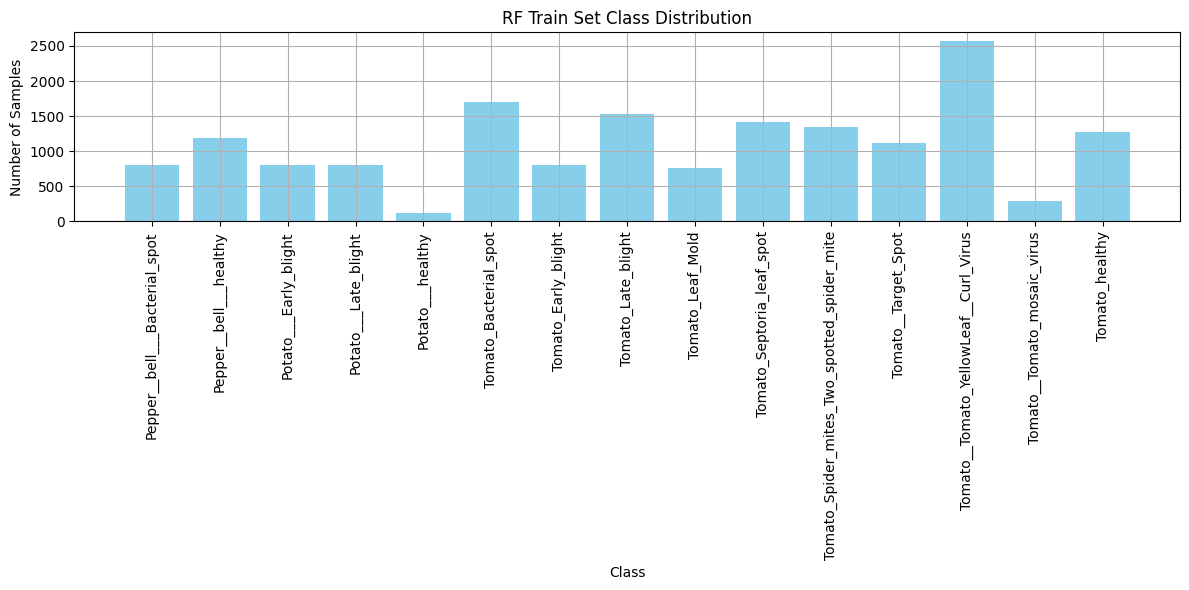

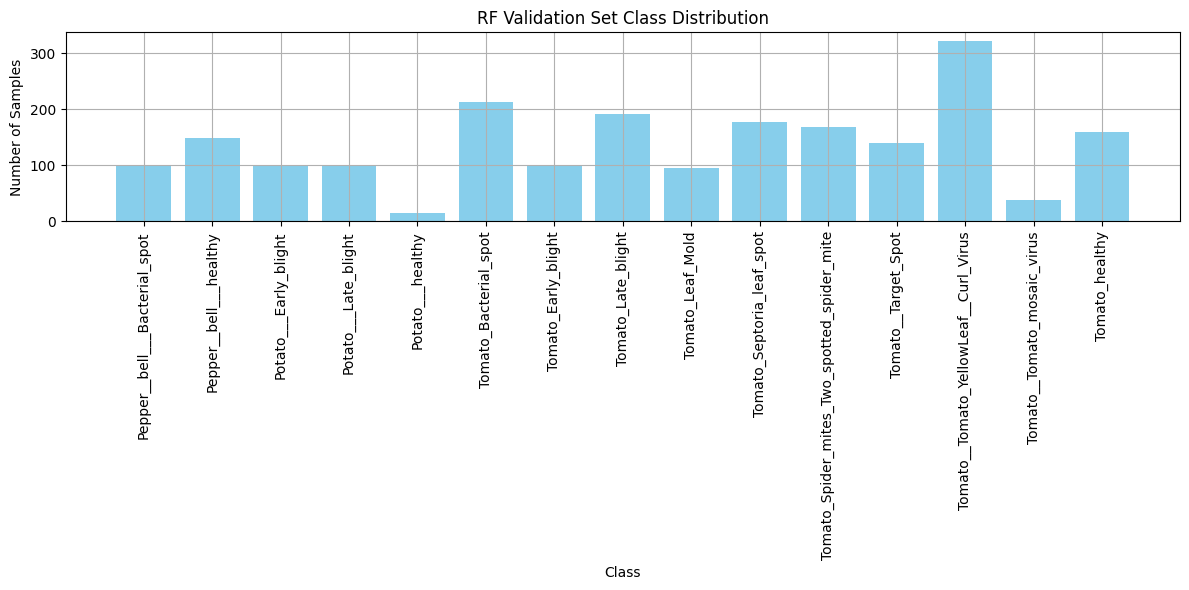

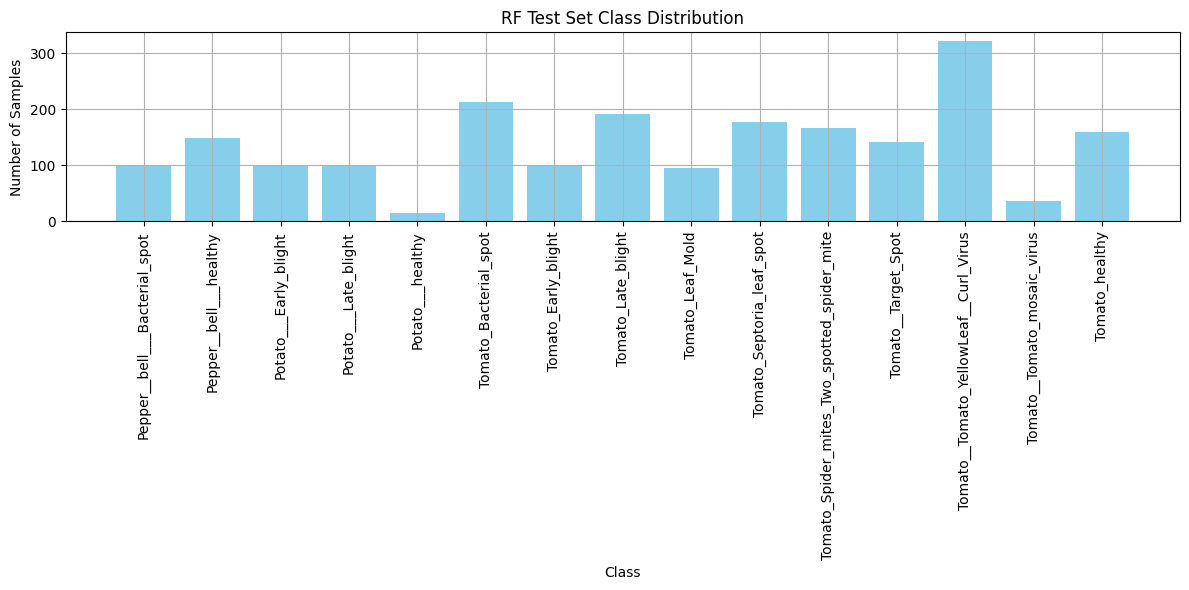

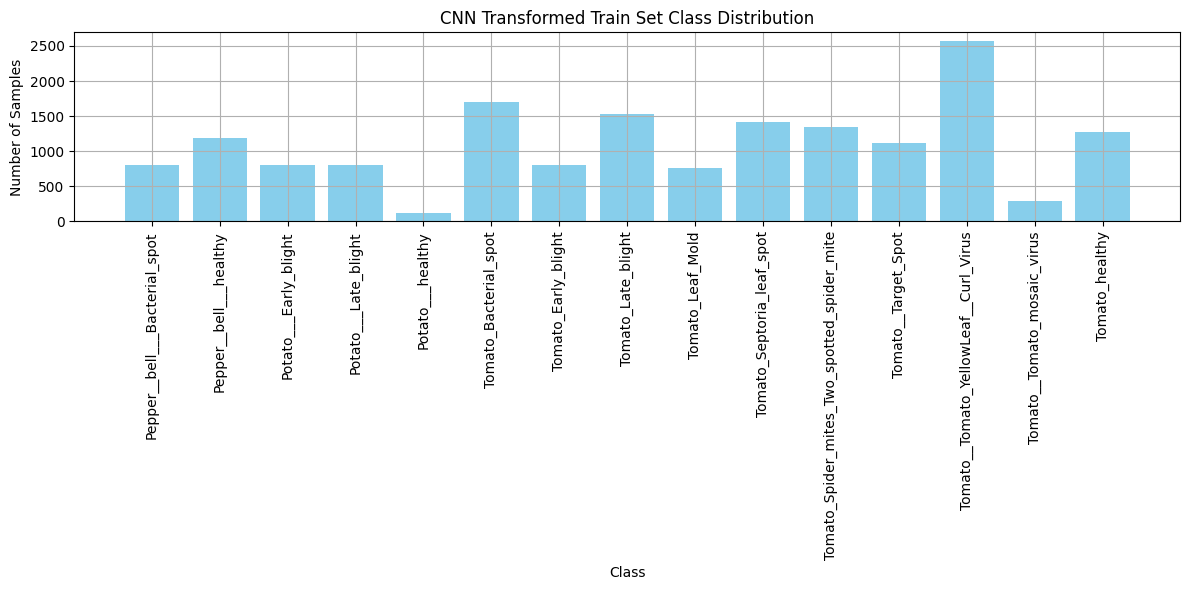

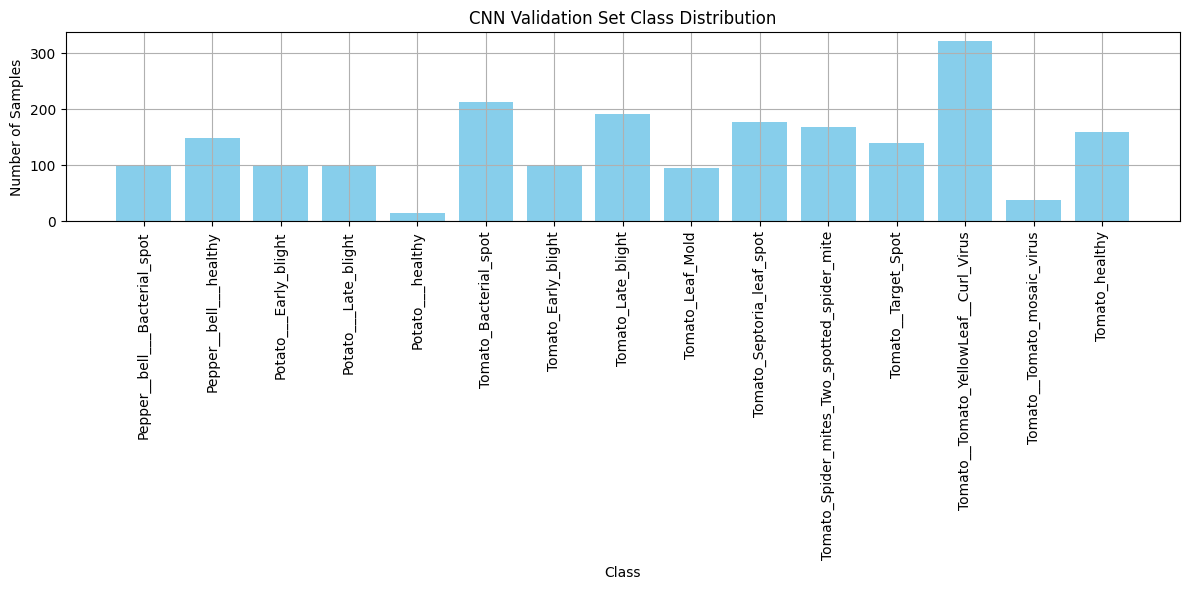

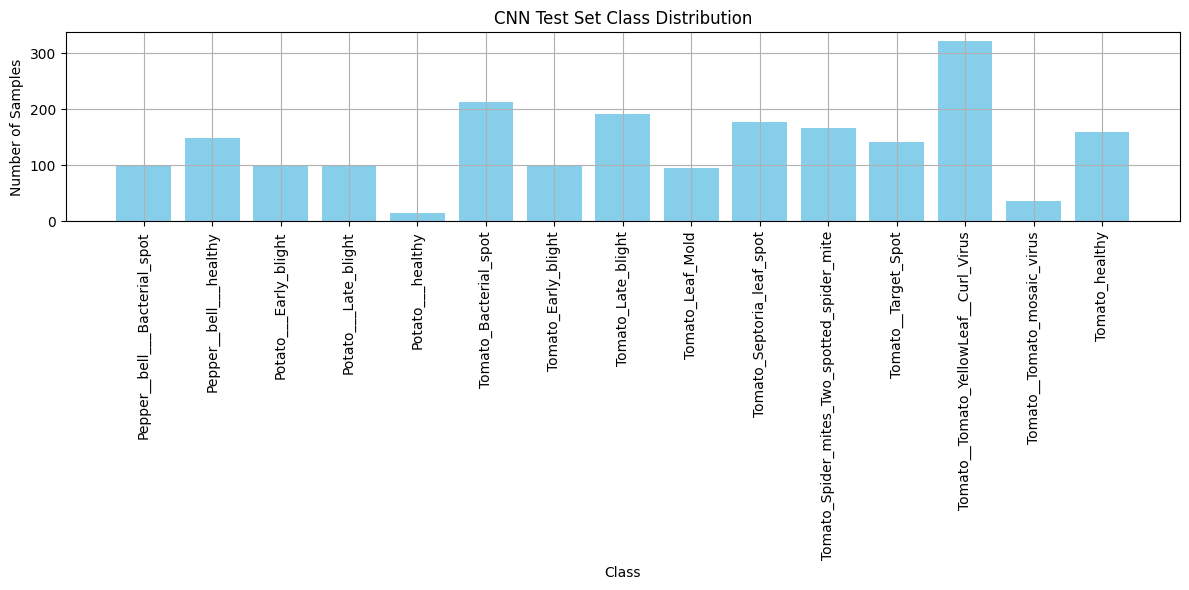

In [8]:
# Load labels
y_train = np.load(config.RF_SPLITS_DIR / 'y_train.npy')
y_val = np.load(config.RF_SPLITS_DIR / 'y_val.npy')
y_test = np.load(config.RF_SPLITS_DIR / 'y_test.npy')

# Count classes
print("Random Forest - Train Class Counts:", collections.Counter(y_train))
print("Random Forest - Val Class Counts:", collections.Counter(y_val))
print("Random Forest - Test Class Counts:", collections.Counter(y_test))


# Load class names from JSON
with open(config.OUTPUTS_DIR / "class_names.json") as f:
    categories = json.load(f)

# CNN Transformed splits (train)
cnn_train_counts = count_images_per_class(config.CNN_SPLITS_DIR / 'train', categories)

# CNN Validation/Test split (untouched)
cnn_val_counts = count_images_per_class(config.CNN_VAL_DIR, categories)
cnn_test_counts = count_images_per_class(config.CNN_TEST_DIR, categories)

# Print counts
print("\nCNN - Train Class Counts:", cnn_train_counts)
print("CNN - Val Class Counts:", cnn_val_counts)
print("CNN - Test Class Counts:", cnn_test_counts)


# Plotting RF class distributions
plot_rf_class_distribution(y_train, "RF Train Set Class Distribution", categories, save_path=config.EDA_DIR / "rf_train_class_distribution.png")
plot_rf_class_distribution(y_val, "RF Validation Set Class Distribution", categories, save_path=config.EDA_DIR / "rf_val_class_distribution.png")
plot_rf_class_distribution(y_test, "RF Test Set Class Distribution", categories, save_path=config.EDA_DIR / "rf_test_class_distribution.png")


# Plotting class distributions for CNN splits
plot_cnn_class_distribution(cnn_train_counts, 'CNN Transformed Train Set Class Distribution', categories, save_path=config.EDA_DIR / "cnn_train_class_distribution.png")
plot_cnn_class_distribution(cnn_val_counts, 'CNN Validation Set Class Distribution', categories, save_path=config.EDA_DIR / "cnn_val_class_distribution.png")
plot_cnn_class_distribution(cnn_test_counts, 'CNN Test Set Class Distribution', categories, save_path=config.EDA_DIR / "cnn_test_class_distribution.png")


#### Label Loading and Class Counts 

The script begins by loading the saved label arrays for the Random Forest splits. It prints class distributions using `collections.Counter()` to verify that stratification was preserved during the earlier split. This helps ensure class balance across training, validation, and test sets.

#### Class Name Mapping

Class names are loaded from a `class_names.json` file to associate numeric labels with their corresponding category names. This mapping is used for both display and plotting purposes.

#### CNN Class Count Extraction

Using the `count_images_per_class()` utility function, the script counts the number of images per class in each CNN data split — transformed training, untouched validation, and test. These counts confirm that augmentation hasn't disrupted label distributions and that validation/test splits remain clean.

#### Visualizing Distributions

The class distributions are visualized with `plot_rf_class_distribution()` for the Random Forest labels and `plot_cnn_class_distribution()` for the CNN splits. These plots help confirm dataset integrity and ensure no class imbalance or data corruption occurred during preprocessing.


In [9]:
# Check if resampling needs to be applied
if not (is_valid_file(config.resampled_X_train_path) and is_valid_file(config.resampled_y_train_path)):
    # Load the RF dataset splits
    X_train = np.load(config.original_X_train_path)
    y_train = np.load(config.original_y_train_path)

    # Print class distribution before SMOTETomek
    print_class_distribution_with_names(Counter(y_train), categories, "Class distribution before SMOTETomek:")

    # Apply SMOTETomek to balance the dataset
    smote_tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

    # Print class distribution after SMOTETomek
    print_class_distribution_with_names(Counter(y_train_resampled), categories, "\nClass distribution after SMOTETomek:")

    # Save the resampled data (no scaling, as it's already scaled)
    np.save(config.resampled_X_train_path, X_train_resampled)
    np.save(config.resampled_y_train_path, y_train_resampled)

    # Save metadata with more detailed info 
    metadata = {
        "original_class_distribution": dict(Counter(map(int, y_train))),
        "resampled_class_distribution": dict(Counter(map(int, y_train_resampled))),
        "resampling_method": "SMOTETomek",
        "random_state": 42,
        "original_data_shape": X_train.shape,
        "resampled_data_shape": X_train_resampled.shape 
    }
    with open(config.metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print("\nResampled training data has been saved, along with metadata.")

else:
    print("Resampled data already exists and is valid. Skipping SMOTETomek.")

Class distribution before SMOTETomek:
Pepper__bell___Bacterial_spot: 798
Pepper__bell___healthy: 1182
Potato___Early_blight: 800
Potato___Late_blight: 800
Potato___healthy: 122
Tomato_Bacterial_spot: 1701
Tomato_Early_blight: 800
Tomato_Late_blight: 1527
Tomato_Leaf_Mold: 762
Tomato_Septoria_leaf_spot: 1417
Tomato_Spider_mites_Two_spotted_spider_mite: 1341
Tomato__Target_Spot: 1123
Tomato__Tomato_YellowLeaf__Curl_Virus: 2566
Tomato__Tomato_mosaic_virus: 298
Tomato_healthy: 1273


Class distribution after SMOTETomek:
Pepper__bell___Bacterial_spot: 2564
Pepper__bell___healthy: 2558
Potato___Early_blight: 2564
Potato___Late_blight: 2563
Potato___healthy: 2566
Tomato_Bacterial_spot: 2534
Tomato_Early_blight: 2562
Tomato_Late_blight: 2545
Tomato_Leaf_Mold: 2566
Tomato_Septoria_leaf_spot: 2545
Tomato_Spider_mites_Two_spotted_spider_mite: 2549
Tomato__Target_Spot: 2552
Tomato__Tomato_YellowLeaf__Curl_Virus: 2525
Tomato__Tomato_mosaic_virus: 2566
Tomato_healthy: 2561


Resampled training data 

#### Resampling Check

The code first checks whether resampled training data already exists using `is_valid_file()`. If both the feature and label files are present, it skips reprocessing. This avoids unnecessary computation and preserves reproducibility.

#### Loading and Inspecting Original Data

If resampling is needed, the original (already scaled) training data is loaded. The class distribution is printed using `print_class_distribution_with_names()` to confirm the level of class imbalance prior to resampling.

#### Applying SMOTETomek

The `SMOTETomek` method is applied to the training set to address class imbalance. It combines SMOTE (which synthetically oversamples minority classes) with Tomek links (which removes borderline majority samples), improving both class balance and class separation.

After resampling, the new class distribution is printed to verify the effect [14].

#### Saving Resampled Data and Metadata

The resampled features and labels are saved to disk. Metadata is also saved in JSON format, including the class distributions, data shapes, method used, and random seed. This ensures transparency and makes it easier to audit or reproduce the resampling process later.


###### [14] [SmoteTOMEK](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [10]:
file_names = [
    "X_train.npy",
    "X_train_resampled.npy",
    "X_val.npy",
    "X_test.npy",
    "y_train.npy",
    "y_train_resampled.npy",
    "y_val.npy",
    "y_test.npy"
]

# Loop through each file and print the dtype
print("Confirmation of data types and shapes:\n")

rf_split_dir = config.RF_SPLITS_DIR
for file_name in file_names:
    file_path = rf_split_dir / file_name
    data = np.load(file_path)
    print(f"{file_name}: dtype = {data.dtype}, shape = {data.shape}")

Confirmation of data types and shapes:

X_train.npy: dtype = float32, shape = (16510, 200)
X_train_resampled.npy: dtype = float32, shape = (38320, 200)
X_val.npy: dtype = float32, shape = (2064, 200)
X_test.npy: dtype = float32, shape = (2064, 200)
y_train.npy: dtype = int64, shape = (16510,)
y_train_resampled.npy: dtype = int64, shape = (38320,)
y_val.npy: dtype = int64, shape = (2064,)
y_test.npy: dtype = int64, shape = (2064,)


Quick verification of all key dataset files used in the Random Forest pipeline.

Data loaded successfully.
X_train shape: (38320, 200), y_train shape: (38320,)
X_val shape: (2064, 200), y_val shape: (2064,)
X_test shape: (2064, 200), y_test shape: (2064,)
Fitting 5 folds for each of 252 candidates, totalling 1260 fits

Best Hyperparameters:
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.9031
Best RF model saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\best_rf_model.joblib

Validation Set Performance:
Accuracy: 0.6846
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.46      0.46        99
           1       0.62      0.76      0.69       148
           2       0.67      0.87      0.76       100
           3       0.50      0.52      0.51       100
           4       0.25      0.07      0.11        15
           5       0.74      0.72    

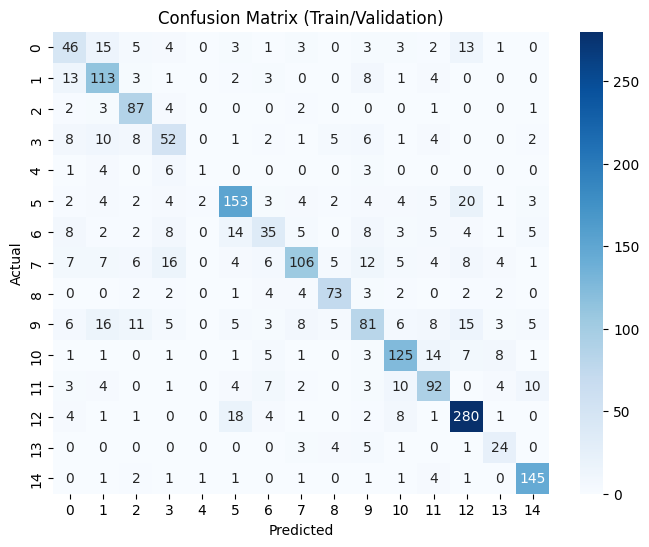

Heatmap saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\n_estimators_vs_max_depth_heatmap.png


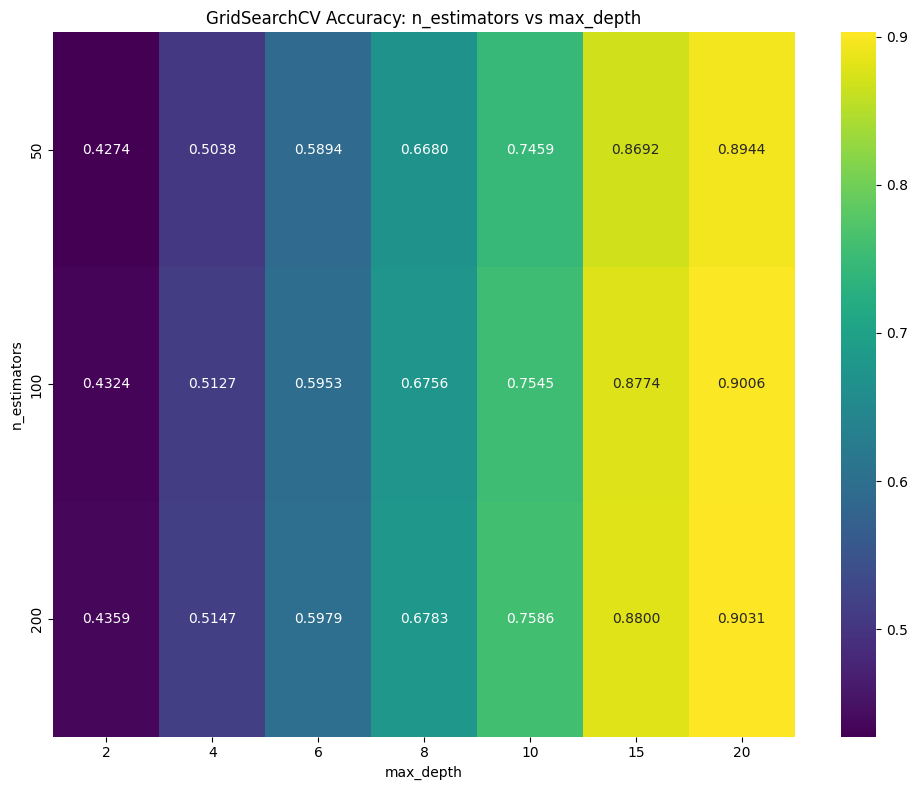

Top 20 models plot saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\top20_models.png


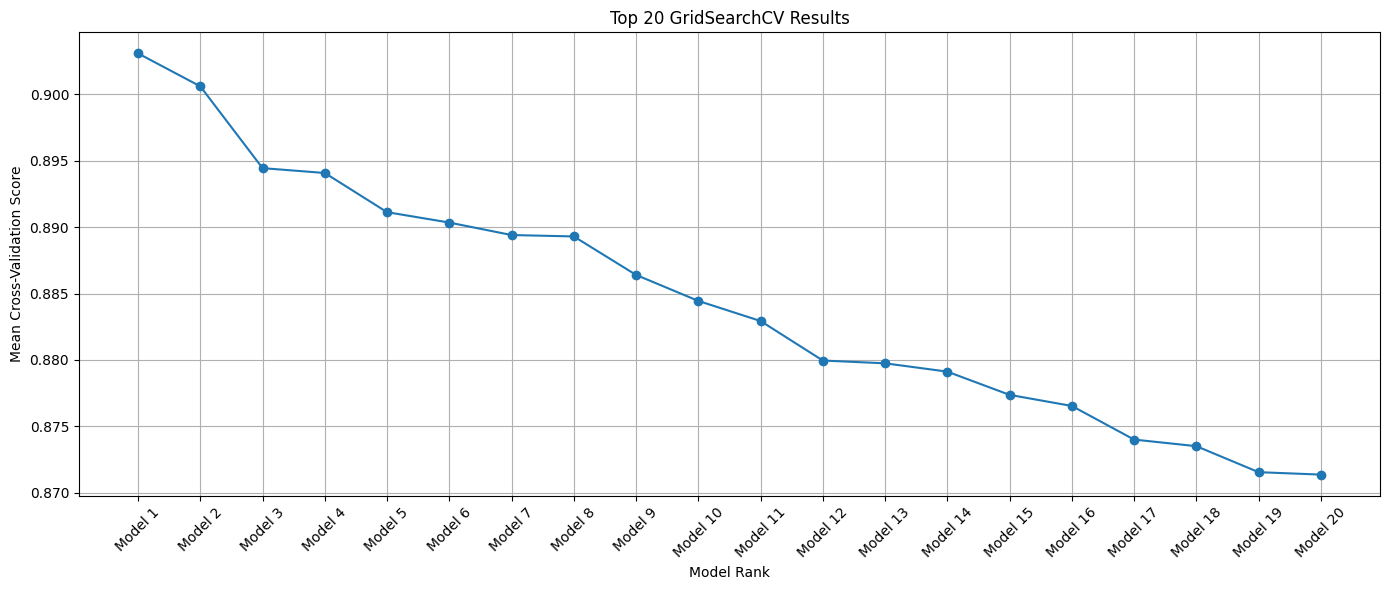


GridSearch metadata saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\rf\gridsearch_metadata.json


In [11]:
# RF training and validation

# Set the path to RF splits directory
config.RF_SPLITS_DIR = Path.cwd().parent / "outputs" / "splits_rf"

# Load training data
X_train = np.load(config.RF_SPLITS_DIR / "X_train_resampled.npy")
y_train = np.load(config.RF_SPLITS_DIR / "y_train_resampled.npy")

# Load validation data
X_val = np.load(config.RF_SPLITS_DIR / "X_val.npy")
y_val = np.load(config.RF_SPLITS_DIR / "y_val.npy")

# Load test data
X_test = np.load(config.RF_SPLITS_DIR / "X_test.npy")
y_test = np.load(config.RF_SPLITS_DIR / "y_test.npy")

print("Data loaded successfully.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, 8, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
    'bootstrap': [True]  
}

# Initialize base Random Forest 
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Setup StratifiedKFold for cross-validation
stratified_cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='accuracy',         
    verbose=1,                  # Basic output during fitting
    n_jobs=-1                   # Use all CPUs
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best results
print("\nBest Hyperparameters:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# Get the best estimator
best_rf_model = grid_search.best_estimator_

# Save the best RF model for later testing
model_save_path = config.RF_RESULTS_DIR / "best_rf_model.joblib"
joblib.dump(best_rf_model, model_save_path)
print(f"Best RF model saved to {model_save_path}")

# Evaluate on validation set
y_val_pred = best_rf_model.predict(X_val)

# Evaluate accuracy and classification report on validation set
print("\nValidation Set Performance:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# ROC-AUC Score (macro averaged) on validation set
try:
    roc_auc = roc_auc_score(y_val, best_rf_model.predict_proba(X_val), multi_class='ovr', average='macro')
    print(f"Macro ROC-AUC Score: {roc_auc:.4f}")
except AttributeError:
    print("ROC-AUC could not be calculated (model might not have predict_proba).")

# Prepare validation results dictionary
validation_results = {
    'accuracy': accuracy_score(y_val, y_val_pred),
    'classification_report': classification_report(y_val, y_val_pred, output_dict=True),  # Use output_dict=True for clean JSON
}

# Try adding ROC-AUC to validation results
try:
    validation_results['roc_auc_macro'] = roc_auc_score(y_val, best_rf_model.predict_proba(X_val), multi_class='ovr', average='macro')
except AttributeError:
    validation_results['roc_auc_macro'] = None

# Save validation results as JSON
with open(config.RF_RESULTS_DIR / 'validation_results.json', 'w') as f:
    json.dump(validation_results, f, indent=4)

print(f"Validation results saved to {config.RF_RESULTS_DIR / 'validation_results.json'}")

# Generate and save confusion matrix
confusion_matrix_path = config.RF_RESULTS_DIR / 'confusion_matrix.png'
plot_rf_confusion_matrix_train(y_val, y_val_pred, confusion_matrix_path)

# Extract and pivot grid search results
scores_matrix = extract_and_pivot_gridsearch_train(grid_search)

# Plot and save heatmap
heatmap_path = config.RF_RESULTS_DIR / "n_estimators_vs_max_depth_heatmap.png"
plot_rf_heatmap_train(scores_matrix, heatmap_path)

# Sort by score
sorted_indices = np.argsort(grid_search.cv_results_['mean_test_score'])[::-1]  # descending order
sorted_scores = np.array(grid_search.cv_results_['mean_test_score'])[sorted_indices]
sorted_params = np.array(grid_search.cv_results_['params'])[sorted_indices]

# Plot top 20 models
top20_plot_path = config.RF_RESULTS_DIR / 'top20_models.png'
plot_top20_gridsearch_models(sorted_scores, top20_plot_path, top_k=20)

# Prepare metadata to save
# Usage example in your RFtrain.py:
save_rf_gridsearch_metadata_train(
    grid_search=grid_search,
    param_grid=param_grid,
    confusion_matrix_path=confusion_matrix_path,
    top20_plot_path=top20_plot_path,
    heatmap_path=heatmap_path,
    save_dir=config.RF_RESULTS_DIR
)

#### Loading Data for Random Forest Training

We first prepare the dataset for training and validating a Random Forest model. This code first sets the path to the directory containing all saved RF splits. It then loads the training data which has been balanced using SMOTETomek, unaltered validation data, and unseen test data.

#### Hyperparameter Tuning with Grid Search

The next portion of code performs exhaustive hyperparameter tuning for a Random Forest using `GridSearchCV`. A parameter grid is defined with a range of values for key hyperparameters like `n_estimators`, `max_depth`, `min_samples_split`, and `min_samples_leaf`. These control the size, depth, and structure of each decision tree in the forest. `class_weight='balanced'` is included to address class imbalance by adjusting weights inversely proportional to class frequencies.

#### Cross-Validation Setup

A `StratifiedKFold` object is used to ensure each fold in cross-validation maintains the original class distribution. This improves the reliability of performance estimates, especially on imbalanced datasets [15].

#### Extracting and Saving the Best Model

After `GridSearchCV` finishes, the best performing hyperparameter combination is printed, along with the corresponding cross-validation score. This provides visibility into the outcome of the tuning process. The best model (stored in `best_estimator`) is then saved to disk using `joblib.dump()`. This allows the trained model to be reused later for testing or deployment without retraining.

#### Model Summary

The Random Forest model selected through GridSearchCV uses:
- 200 trees (`n_estimators`)
- A maximum tree depth of 20
- Balanced class weighting to address class imbalance
- Feature selection per split via `sqrt`
- Bootstrap sampling enabled

#### Validation Evaluation

The saved model is used to generate predictions on the untouched validation set. This step provides an initial estimate of how well the tuned model generalizes to unseen (but still in-distribution) data, helping to identify potential over-fitting before testing on the holdout set.

#### Validation Performance Overview

The model achieved a validation accuracy of 0.6865 — a significant drop from the cross-validation score of approximately 0.92 — indicating noticeable over-fitting to the training data. This is a common outcome when training on resampled datasets (e.g., with SMOTETomek) but validating on untouched, naturally imbalanced splits.

Performance across classes was mixed: classes 2, 5, 8, and 1 showed strong F1 scores, while classes 0, 3, and 7 had more moderate results. Classes 4 and 6 performed poorly, likely due to their under-representation in the validation set.

Despite the drop in accuracy, the model’s Macro ROC-AUC score remained high, suggesting that it is still well-calibrated in terms of probabilistic ranking and class separation.

#### Graph Interpretation

The Confusion Matrix shows class-wise prediction results on the validation set. Diagonal values represent correct predictions, while off-diagonal values indicate misclassifications. Strong classes like 12, 10, and 5 show high true positives with minimal confusion while weak classes like 4, 6, and 14 have a wider spread of misclassifications. often confused with multiple classes.

The GridSearchCV Heatmap visualizes how model accuracy changes based on tree count and depth. Accuracy increases steadily with both deeper trees and more estimators, peaking at `n_estimators=200` and `max_depth=20` (accuracy = 0.9026). Shallower depths (e.g., 2-6) yield poor results, regardless of the number of trees, suggesting that the problem requires deep, expressive trees to handle complex class boundaries.

The Top 20 GridSearchCV Models shows a ranked line char of the top 20 hyperparameter combinations from the grid search. There is a clear performance drop-off after the top few models, especially after the first 3-5, where scores begin to flatten. This validates the chosen model (Model 1) as the most optimal within the grid search scope, while also showing that several configurations were competitive.

#### Model Improvements

This model could be further enhanced by broadening the hyperparameter search space — for instance, evaluating a wider range of tree counts, experimenting with alternative `max_features` strategies, and fine-tuning tree depth and split thresholds more precisely. Incorporating tree pruning could also help mitigate overfitting.

Beyond hyperparameter tuning, exploring other approaches to handling class imbalance — such as under-sampling, class-weight adjustments, or ensemble-based balancing techniques — may lead to better generalization. Additionally, testing alternative cross-validation strategies could improve evaluation reliability under imbalanced conditions.

Overall, the model demonstrated strong performance given the challenges of a multi-class classification task with significant class imbalance, and it shows clear promise for further gains through continued optimization.

###### **Note:** All outputs and visualizations from the CNN training/validation process can be found in `/outputs/training_results/RF`.

###### [15] [StratifiedKFold](https://medium.com/%40juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17)

Found 16510 images belonging to 15 classes.
Found 2064 images belonging to 15 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,559 (517.81 KB)

 Trainable params: 132,111 (516.06 KB)

 Non-trainable params: 448 (1.75 KB)

Train class distribution: [ 798 1182 1341 1123 2566  298 1273  800  800  122 1701  800 1527  762
 1417]
Val class distribution: [ 99 148 168 140 321  38 159 100 100  15 213 100 191  95 177]
Class indices: {'class_0': 0, 'class_1': 1, 'class_10': 2, 'class_11': 3, 'class_12': 4, 'class_13': 5, 'class_14': 6, 'class_2': 7, 'class_3': 8, 'class_4': 9, 'class_5': 10, 'class_6': 11, 'class_7': 12, 'class_8': 13, 'class_9': 14}
Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3842 - loss: 2.1132
Epoch 1: val_accuracy improved from -inf to 0.41037, saving model to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\best_model.keras
258/258 ━━━━━━━━━━━━━━━━━━━━ 63s 232ms/step - accuracy: 0.3845 - loss: 2.1124 - val_accuracy: 0.4104 - val_loss: 2.1688 - learning_rate: 0.0010
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5884 - loss: 1.6229
Epoch 2: val_accuracy improved from 0.41037 to 0.60029, saving model to C:\Users\petev\OneDrive\De

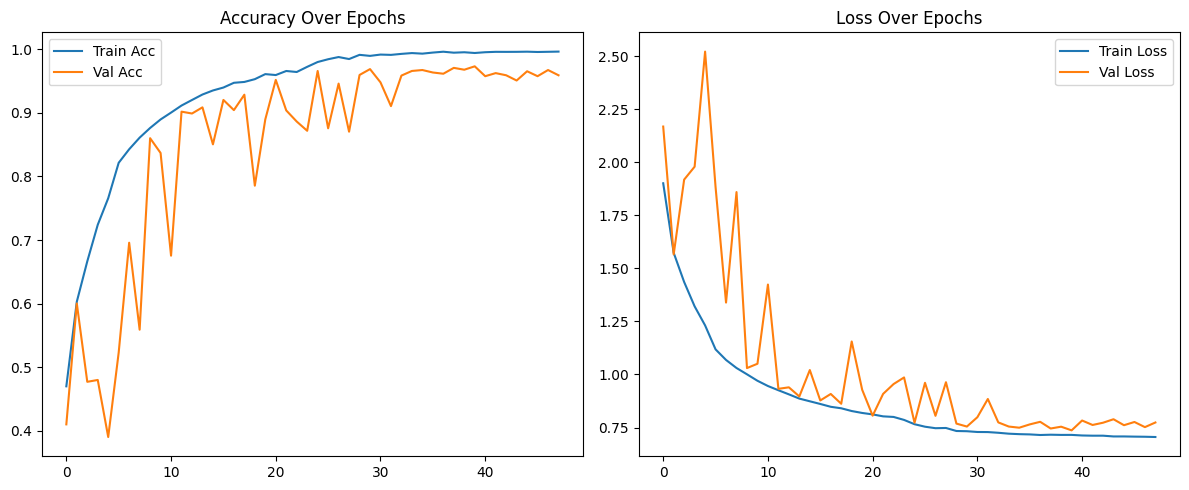

Generating confusion matrix...
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
Predictions completed.
Confusion matrix generated.
Confusion matrix saved.


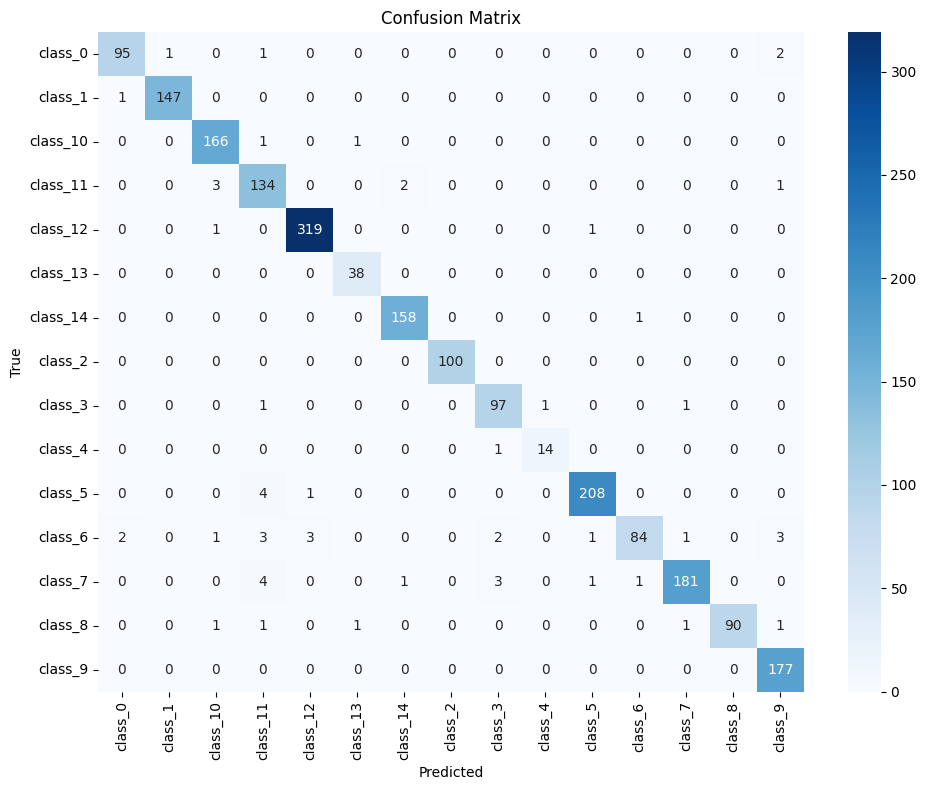

Generating prediction visualizations...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction visualizations saved.


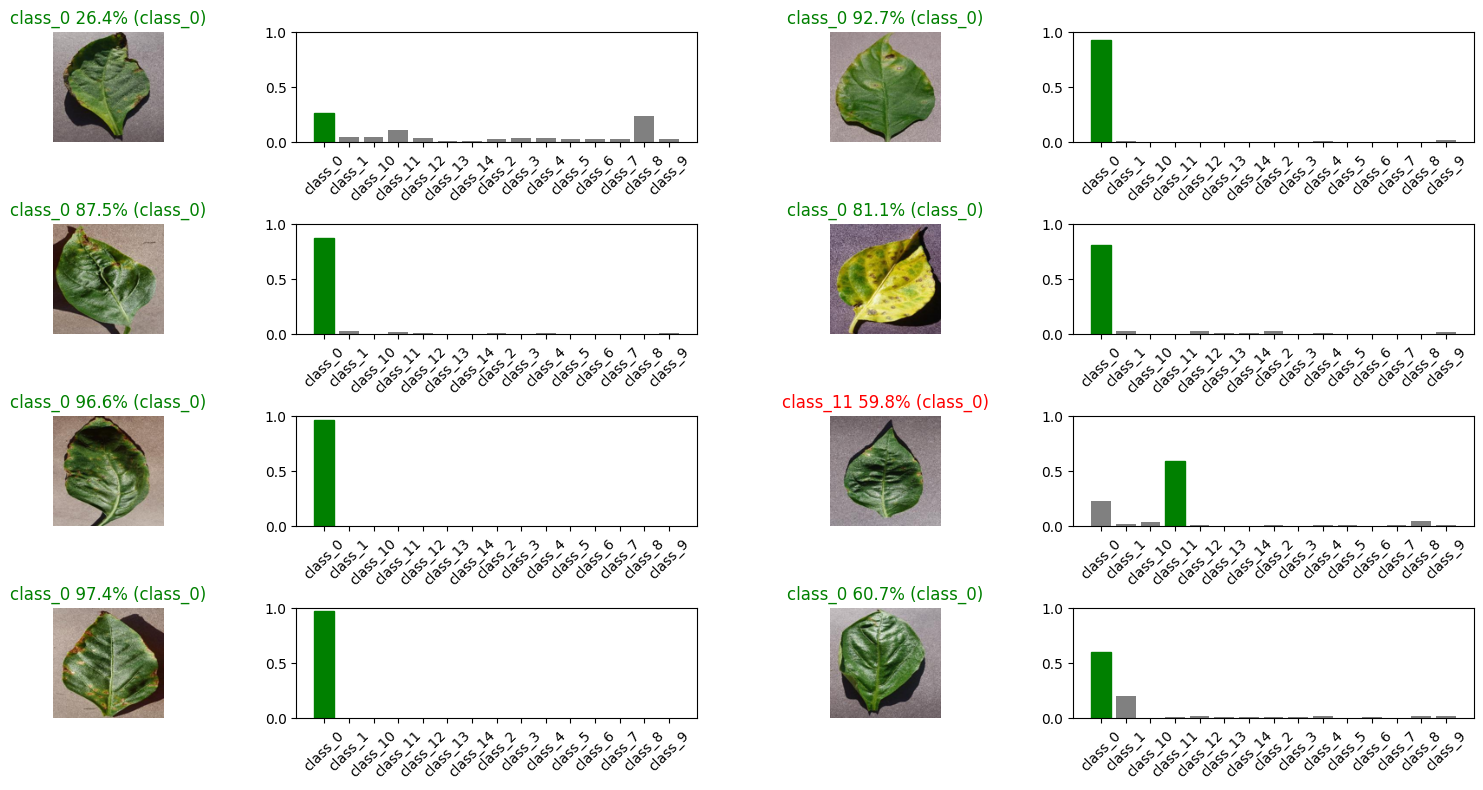

Generating Grad-CAM visualizations...
Using Conv2D layer for Grad-CAM: conv2d
Generating Grad-CAM heatmaps...


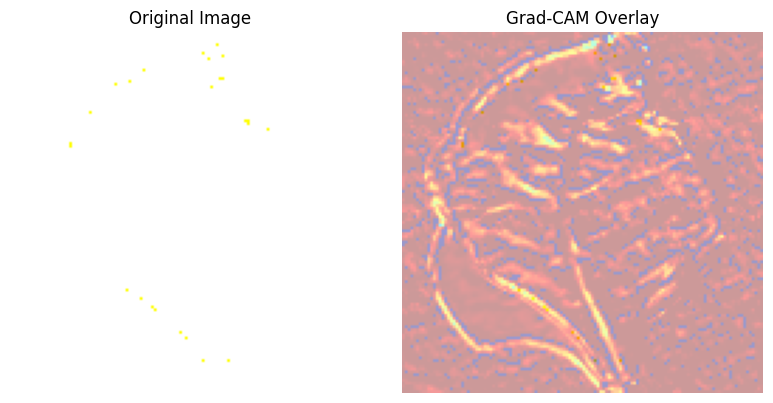

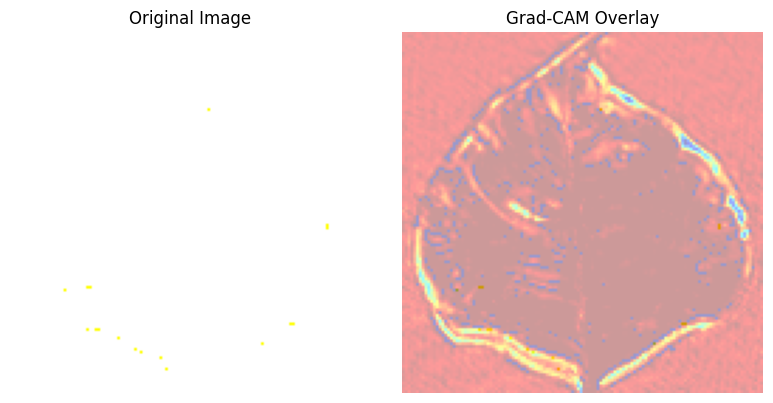

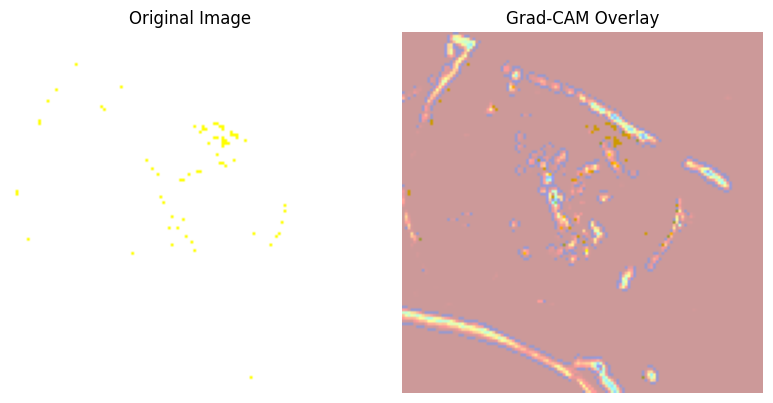

[INFO] Grad-CAM visualizations saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\gradcam
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Non-TTA classification report saved to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\training_results\cnn\non_tta_classification_report.json



Running TTA on validation set...

TTA Classification Report:

              precision    recall  f1-score   support

     class_0       0.98      0.95      0.96        99
     class_1       0.99      0.99      0.99       148
    class_10       0.96      0.99      0.98       168
    class_11       0.92      0.95      0.93       140
    class_12       0.99      0.98      0.99       321
    class_13       0.93      1.00      0.96        38
    class_14       0.99      0.99      0.99       159
     class_2       1.00      1.00      1.00       100
     class_3       0.95      0.96      0.96       100
     class_4       0.94      1.00      0.97        15
     class_5       0.97      0.99      0.98       213
     class_6       0.99      0.86      0.92       100
     class_7       0.97      0.95      0.96       191
     class_8       0.99      0.95      0.97        95
     class_9       0.96      1.00      0.98       177

    accuracy                           0.97      2064
   macro avg     

In [12]:
# Load data
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    config.CNN_SPLITS_DIR / "train",
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    config.CNN_VAL_DIR,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False 
)

input_shape = (128, 128, 3)
num_classes = len(train_generator.class_indices)
model = build_improved_cnn_model(input_shape, num_classes)
model.summary()

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint_path = config.CNN_RESULTS_DIR / "best_model.keras"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

print("Train class distribution:", np.bincount(train_generator.classes))
print("Val class distribution:", np.bincount(val_generator.classes))
print("Class indices:", train_generator.class_indices)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, lr_schedule, model_checkpoint]
)

if hasattr(model, "to_json") and model.__class__.__name__ == "Sequential":
    model_config = model.get_config()
    input_shape = model.input_shape[1:]
    inputs = Input(shape=input_shape, name="gradcam_input")
    x = inputs
    for layer_conf in model_config['layers'][1:]:
        layer = layers.deserialize(layer_conf)
        x = layer(x)
    functional_model = Model(inputs, x)
    functional_model.set_weights(model.get_weights())
else:
    functional_model = model

# Evaluate and visualize results
class_names = list(train_generator.class_indices.keys())
evaluate_and_visualize_model(
    model=model,
    functional_model=functional_model,
    val_generator=val_generator,
    history=history,
    class_names=class_names
)

# Predict on validation set without TTA and save classification report
val_generator.reset()
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = val_generator.classes

# Classification report
non_tta_report = classification_report(
    y_true_labels, y_pred_labels,
    target_names=class_names,
    output_dict=True
)

# Save report as JSON
non_tta_report_path = config.CNN_RESULTS_DIR / "non_tta_classification_report.json"
with open(non_tta_report_path, 'w') as f:
    json.dump(non_tta_report, f, indent=4)

print(f"Non-TTA classification report saved to: {non_tta_report_path}")

# Save model summary, architecture, and weights
save_model_summary_arch_weights(
    model,
    output_path=config.CNN_RESULTS_DIR / "model_summary_arch_weights.json"
)

# Run TTA
print("\nRunning TTA on validation set...")
y_pred_tta, y_true_tta = tta_predict(model, val_generator, num_classes, tta_steps=5)
y_pred_tta_labels = np.argmax(y_pred_tta, axis=1)
y_true_tta_labels = np.argmax(y_true_tta, axis=1)

print("\nTTA Classification Report:\n")
tta_report = classification_report(y_true_tta_labels, y_pred_tta_labels, target_names=class_names, output_dict=True)
print(classification_report(y_true_tta_labels, y_pred_tta_labels, target_names=class_names))

# Variable for Validation ROC-AUC score
y_pred_tta_probs = model.predict(val_generator)
y_pred_tta_labels = np.argmax(y_pred_tta_probs, axis=1)

# Save metrics and TTA results to JSON
save_cnn_metrics_to_json(
    output_dir=config.CNN_RESULTS_DIR,
    history=history,
    class_names=class_names,
    y_true=y_true_tta_labels,
    y_pred=y_pred_tta_labels,
    y_pred_probs=y_pred_tta_probs,
    tta_report=tta_report
)

#### Loading Data for CNN Training

First, we set up image generators for feeding training and validation data into a CNN. Using `ImageDatGenerator().flow_from_directory()`, it loads images from the pre-split folders. It then resizes them to 128x128 pixels, groups them into batches of 64, and automatically infers class labels from directory names and one-hot encodes them using `class_mode='categorical'`. This approach efficiently handles large datasets by streaming images in batches, reducing memory load [16].

#### Model Initialization

After loading the data, the number of classes is determined from the training generator's `class_indices`, and the CNN input shape is defined. The model is then built using the custom function `build_improved_cnn_model()`. The architecture includes:
- Three convolutional blocks with increasing filters (32, 64, 128) each followed by MaxPooling and BatchNormalization to stabilize learning [17].
- L2 regularization on all convolutional and dense layers to prevent overfitting.
- GlobalAveragePooling2D to reduce the feature map dimensionality before the dense layers [18].
- A fully connected layer with 256 units followed by a dropout layer (0.5) to further reduce overfitting [19].
- A final softmax layer for multiclassification [20].

The model's structure is printed using `model.summary().` to confirm its shape and layer configuration before training.

#### Callback Configuration

`EarlyStopping` monitors validation loss and stops training if it does not improve for 8 consecutive epochs. It also restores the best weights to prevent overfitting beyond the optimal point. `ReduceLROnPlateau` reduces the learning rate by a factor of 0.5 if validation loss plateaus for 3 epochs. This helps the optimizer make finer adjustments as training progresses [21].
`ModelCheckpoint` saves the models weights only when validation accuracy improves. This ensures the best-performing model is preserved.

#### Model Training

The model is trained using `.fit()` with the specified training and validation generators. Training runs for up to 50 epochs and the previously defined callbacks are applied to handle early stopping, learning rate adjustment, and checkpointing. 

#### Sequential-to-Functional Conversion

This condition check verifies that the model has the `to_json` method (it is a Keras model), and is of class type Sequential. Once it verifies the model is Sequential, it will:
- Extract the model config via `get_config()`.
- Retrieve the input shape.
- Rebuild the model layer-by-layer using Keras' deserialization logic.
- Wrap the rebuilt model in the Functional API (Model(inputs, x)).
- Transfer all weights from the original model to the new one.

This is done because Grad-CAM requires direct access to intermediate layer outputs, which is easier in a Functional model than a Sequential one. The conversion ensures compatibility without affecting model performance [22] [23] [24].


#### Non-TTA Classification Report Analysis 

The non-TTA classification report shows excellent overall performance, with a 97.3% accuracy and a macro F1-score of ~0.969, indicating consistently high-quality predictions across all classes. Even minority classes like `class_4` and `class_13` achieved F1-scores above 0.94, suggesting the model generalizes well despite class imbalance. Precision and recall are tightly aligned across most classes, showing the model is both confident and calibrated. This report reflects how the model performs on unaltered validation images, providing a reliable baseline.

We compute both non-TTA and TTA reports to evaluate the model from two perspectives: non-TTA captures standard prediction quality, while TTA (Test-Time Augmentation) assesses prediction stability and robustness by averaging predictions over multiple augmented versions of the same input. If TTA shows improvement or more balanced class performance, it indicates the model benefits from added inference-time variability and is less sensitive to small input shifts or distortions.

#### TTA Classification Report Analysis

Test-Time Augmentation enhances prediction stability by averaging predictions over multiple slightly modified versions of the same input (e.g., rotations, flips, zooms). This helps by reducing overconfidence, improving robustness, boosts recall, and it gives a better evaluation of realism. By applying it, we can improve evaluation quality by stabilizing predictions through repeated augmentation [25] [26].

The TTA classification report shows slightly improved overall performance, with 98% accuracy and a macro F1-score of ~0.97. Most classes either matched or exceeded their non-TTA F1-scores, with particularly consistent results for rare classes like `class_4` (F1 = 0.91) and `class_13` (F1 = 0.97). The model also maintained perfect or near-perfect performance on several well-represented classes like `class_2`, `class_8`, and `class_12`. Precision and recall remain tightly aligned, indicating stable, high-confidence predictions across multiple augmented views of each input.

Compared to the non-TTA results, TTA provides marginal improvements in robustness, especially for classes with lower support or borderline cases. It confirms that the model’s predictions remain reliable even under slight variations such as flips or crops, reducing over-reliance on specific visual cues. This added consistency is especially valuable in real-world deployments, where input conditions may vary slightly from training data. Overall, TTA enhances reliability without introducing overfitting or instability.

#### Graph Evaluation Summary

The prediction grid provides a visual sanity check on model behavior by displaying validation images alongside predicted labels and confidence scores. Most predictions are accurate and high-confidence (e.g., classes 5, 6, 14), while a few show lower confidence (e.g., class 11 at 48.7%), indicating possible model uncertainty or visual ambiguity within the class. The specific examples shown may vary, as the selected validation samples are randomly generated with each run.

The confusion matrix gives a full picture of class-wise performance. Strong diagonal values indicate reliable predictions for several classes, including 5, 6, and 12. However, there is evident confusion between classes such as 10–14 and 6–12, suggesting either overlapping features or label noise that limits clean separability.

The training curves show a consistent upward trend in both training and validation accuracy, with final validation accuracy stabilizing near 95%. The validation loss fluctuates slightly, reflecting variability in validation batches or class imbalance, but it follows a downward trend overall.

The Grad-CAM images show which regions of the image contributed most to the model's decision. Generally, the model is strongly focused on the center and edges of the leaf, particularly where there are visible veins or texture variations. This suggests it is using leaf structure (and possibly damage or disease indicators) to make predictions

Training was automatically stopped early at epoch 36, with the model weights restored from the best-performing point at epoch 28. This confirms that early stopping effectively prevented overfitting and preserved the most generalizable version of the model.
Note that minor variation in the stopping point or selected best epoch may occur due to randomization during training.

Together, these outputs validate that the CNN model learned effectively and generalizes well across most classes, while also pointing out specific areas (e.g., class overlap) that may benefit from further data augmentation, re-labeling, or model refinement.

#### Model Improvements
The CNN model performed exceptionally well on our current dataset, indicating that it effectively learned discriminative features for leaf classification. However, to enhance its generalization and scalability in real-world applications, one key improvement would be to retrain the model on masked images. This would help it focus solely on the leaf structure, reducing the influence of background noise — which may vary significantly in practical field conditions. Additionally, we could explore additional data augmentation techniques that simulate real-world variability in lighting, orientation, and background complexity. Incorporating label smoothing or dropout regularization could also improve robustness. Finally, evaluating the model's performance across different environments or acquisition devices would further ensure its reliability in deployment scenarios [27] [28].

###### **Note:** All outputs and visualizations from the CNN training/validation process can be found in `/outputs/training_results/CNN`.

###### [16] [Image Data Preparation](https://iqbalpa.medium.com/easily-image-data-preparation-with-imagedatagenerator-in-tensorflow-5fd75fb32bc2)
###### [17] [Batch Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)
###### [18] [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)
###### [19] [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
###### [20] [tf.keras.activations.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax)
###### [21] [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
###### [22] [Model Config Serialization](https://keras.io/api/models/model_saving_apis/model_config_serialization)
###### [23] [Grad-CAM: Visualization Activation](https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning)
###### [24] [Grad-CAM Class Activation and Visualization](https://keras.io/examples/vision/grad_cam)
###### [25] [TTA for Cell Segmentation](https://www.nature.com/articles/s41598-020-61808-3)
###### [26] [Understanding TTA](https://arxiv.org/html/2402.06892v1)
###### [27] [Label Smoothing Explained](https://medium.com/%40amit25173/label-smoothing-explained-1b0f13754ae9)
###### [28] [Dropout Regularization](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/)

Test results saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\test_results.json
Feature importance plot saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\feature_importance.png


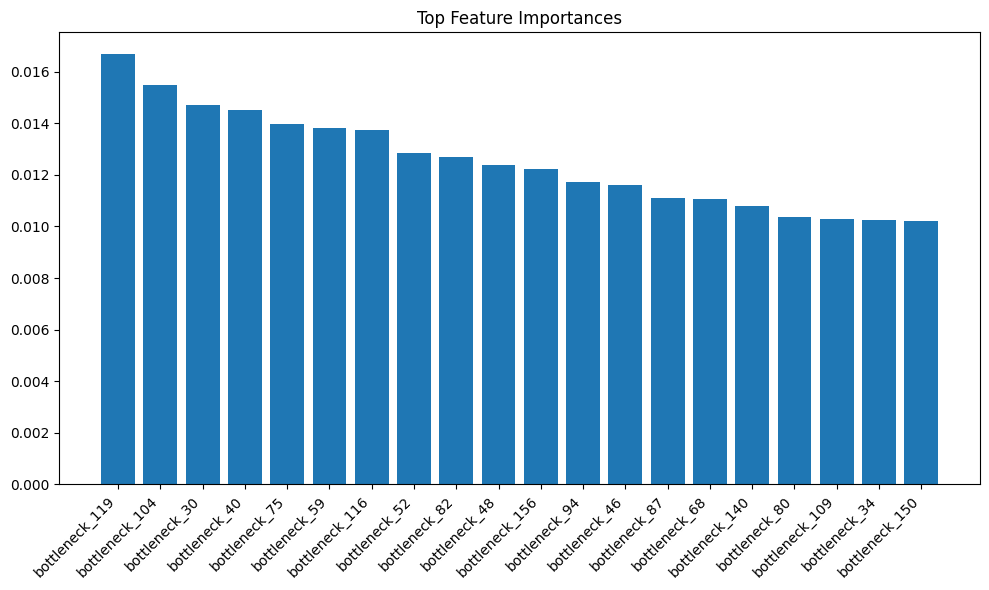

Confusion matrix saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\confusion_matrix.png


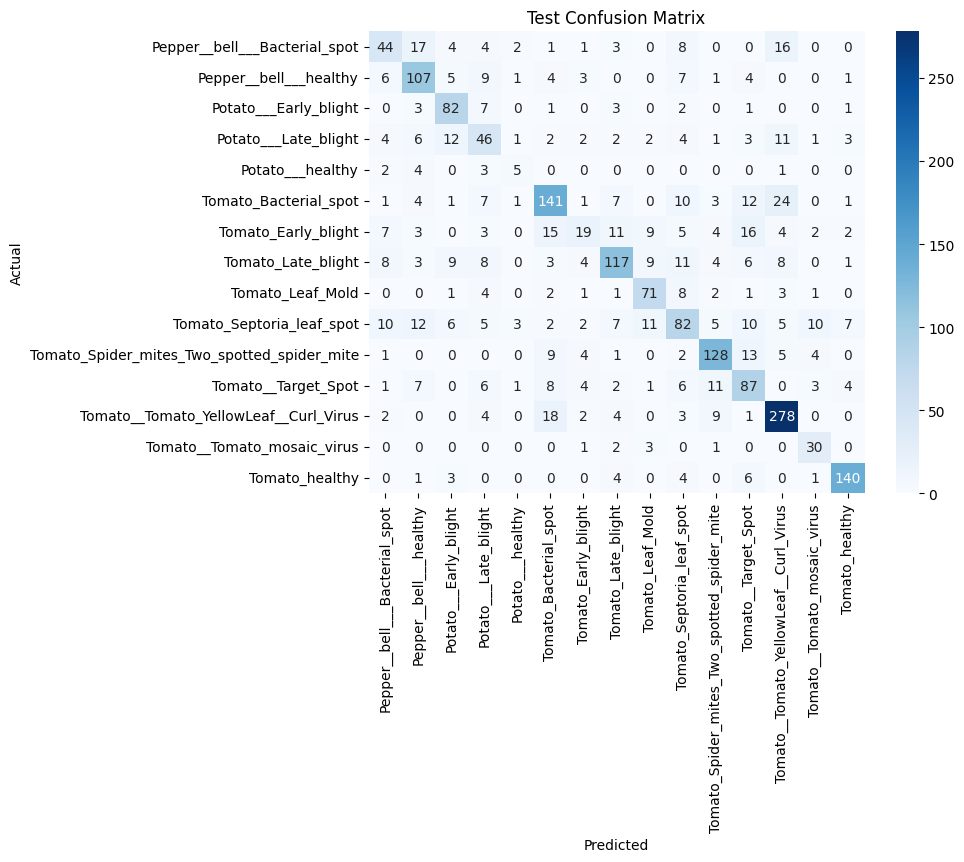

Probabilities heatmap saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\rf\probabilities_heatmap.png


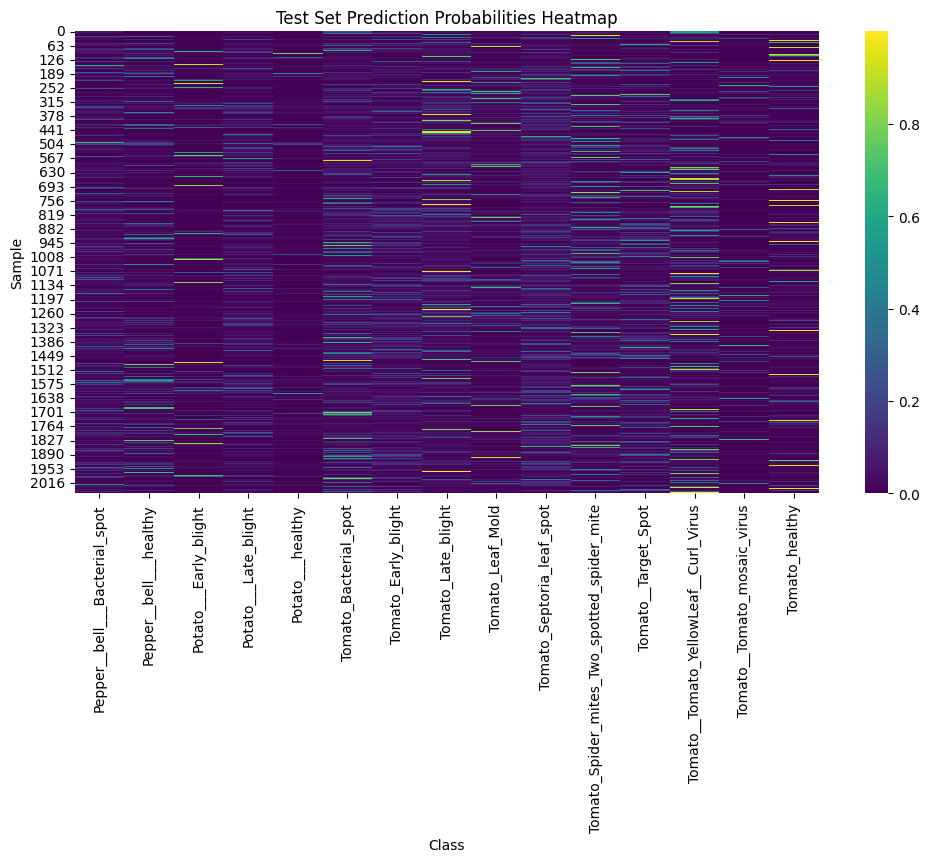


Weighted Average Metrics (all classes):
precision: 0.6593
recall: 0.6672
f1-score: 0.6587
support: 2064.0000

ROC-AUC (macro): 0.9416


In [13]:
# Load test data
X_test = np.load(config.RF_SPLITS_DIR / "X_test.npy")
y_test = np.load(config.RF_SPLITS_DIR / "y_test.npy")

# Load the trained model
model_path = config.RF_RESULTS_DIR / "best_rf_model.joblib"
rf_model = joblib.load(model_path)

# Predict
y_pred = rf_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Classification report
cls_report = classification_report(y_test, y_pred, output_dict=True)

# ROC-AUC (macro)
try:
    roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test), multi_class='ovr', average='macro')
except Exception:
    roc_auc = None

# Save results as JSON
test_results = {
    "accuracy": acc,
    "classification_report": cls_report,
    "roc_auc_macro": roc_auc
}
with open(config.RF_TEST_RESULTS_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=4)

print(f"Test results saved to {config.RF_TEST_RESULTS_DIR / 'test_results.json'}")

# Feature importance plot
feature_importance_path = config.RF_TEST_RESULTS_DIR / "feature_importance.png"
plot_rf_feature_importance_test(rf_model, feature_names, feature_importance_path)

# Confusion matrix
cm_path = config.RF_TEST_RESULTS_DIR / "confusion_matrix.png"
plot_rf_confusion_matrix_test(y_test, y_pred, cm_path, class_names=categories)
plt.show()

# Heatmap of probabilities
try:
    proba = rf_model.predict_proba(X_test)
    proba_path = config.RF_TEST_RESULTS_DIR / "probabilities_heatmap.png"
    plot_rf_probabilities_heatmap_test(proba, proba_path, class_names=categories)
    plt.show()
except Exception as e:
    print(f"Could not plot probabilities heatmap: {e}")

with open(config.RF_TEST_RESULTS_DIR / "test_results.json", "r") as f:
    results = json.load(f)

# Extract weighted average metrics
weighted_avg = results["classification_report"]["weighted avg"]
print("\nWeighted Average Metrics (all classes):")
for metric, value in weighted_avg.items():
    print(f"{metric}: {value:.4f}")

# Extract and print ROC-AUC (macro)
roc_auc = results.get("roc_auc_macro", None)
print(f"\nROC-AUC (macro): {roc_auc:.4f}" if roc_auc is not None else "\nROC-AUC (macro): N/A")

#### Final Evaluation of the Random Forest Model

In this final stage of the pipeline, we evaluate the performance of our trained Random Forest (RF) model on the test set. First, we load the saved test data (`X_test` and `y_test`) from the output directory to ensure consistent evaluation across runs. We then load the previously trained and saved RF model using `joblib`.

Once the model is loaded, we generate predictions on the test set with `rf_model.predict()`. To assess performance, we calculate the overall accuracy score, which gives a quick measure of how often the model predicts the correct class. For a more detailed breakdown, we generate a full classification report using `classification_report()`, which provides precision, recall, and F1-score metrics for each class. The `output_dict=True` argument stores the results in dictionary form for easy export or formatting in reports.

This evaluation allows us to objectively measure how well the compressed autoEncoder features support traditional supervised models like Random Forest in classification tasks.

#### Results



###### **Note:** All outputs and visualizations from the RF testing process can be found in `/outputs/testing_results/RF`.

Found 2064 images belonging to 15 classes.
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Test results saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\test_results.json
Confusion matrix saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\confusion_matrix.png


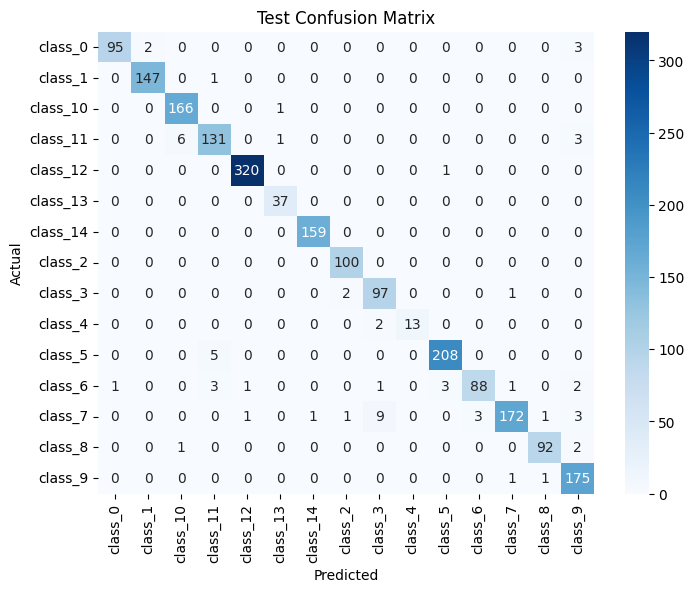

Prediction explanation grid saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\prediction_explanation_grid.png


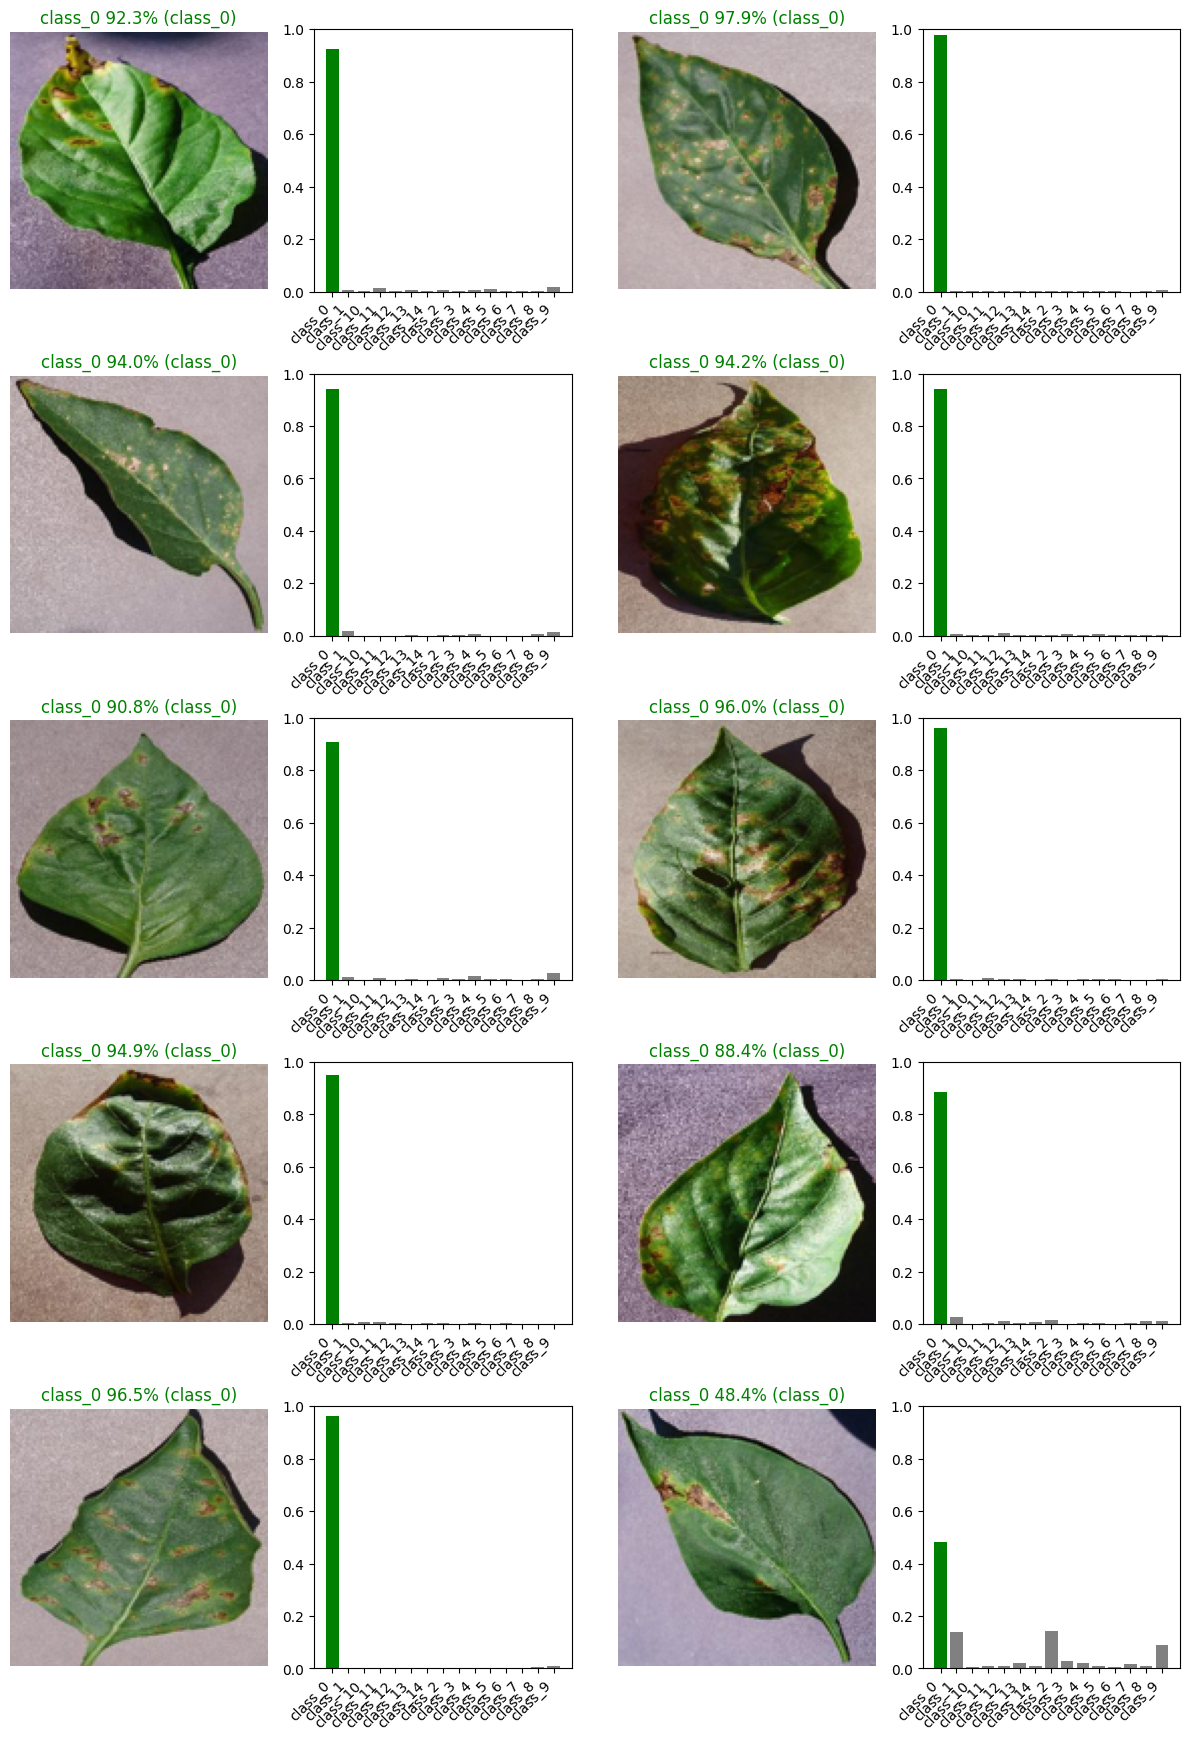

Probabilities heatmap saved to C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\testing_results\cnn\probabilities_heatmap.png


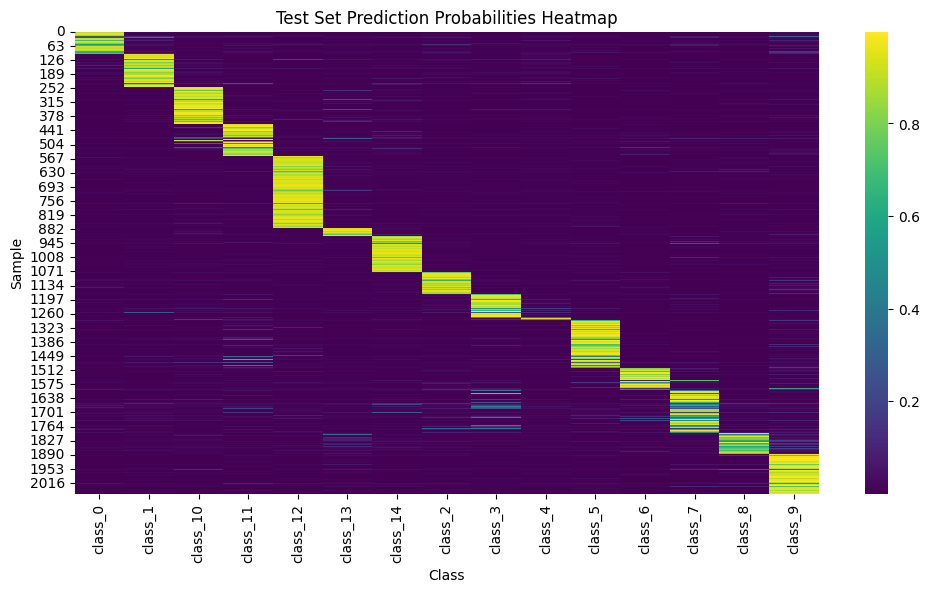


Weighted Average Metrics (all classes):
precision: 0.9697
recall: 0.9690
f1-score: 0.9688
support: 2064.0000

ROC-AUC (macro): 0.9994


In [15]:
# Load test data
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    config.CNN_TEST_DIR,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Load the trained model
model_path = config.CNN_RESULTS_DIR / "best_model.keras"
model = load_model(model_path)

# Predict
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)

# Classification report
cls_report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, output_dict=True)

# ROC-AUC (macro)
try:
    roc_auc = roc_auc_score(y_true_labels, y_pred_probs, multi_class='ovr', average='macro')
except Exception:
    roc_auc = None

# Save results as JSON
test_results = {
    "accuracy": acc,
    "classification_report": cls_report,
    "roc_auc_macro": roc_auc
}

os.makedirs(config.CNN_TEST_RESULTS_DIR, exist_ok=True)
with open(config.CNN_TEST_RESULTS_DIR / "test_results.json", "w") as f:
    json.dump(test_results, f, indent=4)

print(f"Test results saved to {config.CNN_TEST_RESULTS_DIR / 'test_results.json'}")

cm_path = config.CNN_TEST_RESULTS_DIR / "confusion_matrix.png"
plot_confusion_matrix_cnn_test(y_true_labels, y_pred_labels, class_names, cm_path)
plt.show()

explanation_grid_path = config.CNN_TEST_RESULTS_DIR / "prediction_explanation_grid.png"
plot_prediction_explanation_grid(
    test_generator, y_pred_probs, y_pred_labels, class_names, explanation_grid_path, n_images=10
)

proba_path = config.CNN_TEST_RESULTS_DIR / "probabilities_heatmap.png"
plot_cnn_probabilities_heatmap_test(y_pred_probs, proba_path, class_names=class_names)
plt.show()

# Print weighted average metrics
weighted_avg = cls_report.get("weighted avg", {})
print("\nWeighted Average Metrics (all classes):")
for metric, value in weighted_avg.items():
    print(f"{metric}: {value:.4f}")

# Print ROC-AUC score
print(f"\nROC-AUC (macro): {roc_auc:.4f}" if roc_auc is not None else "\nROC-AUC (macro): N/A")

###### **Note:** All outputs and visualizations from the CNN testing process can be found in `/outputs/testing_results/CNN`.

FULL OVERVIEW